# US Airlines Flight Delay Analysis

**Objective:**  
- Identify factors that contribute to *avoidable* flight delays  
- Build models to predict if a flight will be delayed

**Datasets:**
- `airlines.xlsx` – flights and delays
- `airports.xlsx` – airport information
- `runways.xlsx` – runway information

This notebook covers:
1. Data loading and merging
2. Missing value analysis & treatment
3. Feature engineering (airline age, airport traffic, etc.)
4. Exploratory data analysis & visualizations
5. Hypothesis testing
6. Model building (Logistic Regression with SGD, Decision Tree, Gradient Boosting)
````````````````````````````````````````````````

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)


In [2]:
airlines = pd.read_excel("Airlines.xlsx")
airports = pd.read_excel("airports.xlsx")
runways = pd.read_excel("runways.xlsx")


In [3]:
airlines.head()

,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay
0,1,CO,269,SFO,IAH,3,15,205,1
1,2,US,1558,PHX,CLT,3,15,222,1
2,3,AA,2400,LAX,DFW,3,20,165,1
3,4,AA,2466,SFO,DFW,3,20,195,1
4,5,AS,108,ANC,SEA,3,30,202,0


In [4]:
airports.head()

,id,ident,type,name,latitude_deg,longitude_deg,elevation_ft,continent,iso_country,iso_region,municipality,scheduled_service,gps_code,iata_code,local_code,home_link,wikipedia_link,keywords
0,6523,00A,heliport,Total Rf Heliport,40.070801,-74.933601,11.0,NaN,US,US-PA,Bensalem,no,00A,NaN,00A,NaN,NaN,NaN
1,323361,00AA,small_airport,Aero B Ranch Airport,38.704022,-101.473911,3435.0,NaN,US,US-KS,Leoti,no,00AA,NaN,00AA,NaN,NaN,NaN
2,6524,00AK,small_airport,Lowell Field,59.947733,-151.692524,450.0,NaN,US,US-AK,Anchor Point,no,00AK,NaN,00AK,NaN,NaN,NaN
3,6525,00AL,small_airport,Epps Airpark,34.864799,-86.770302,820.0,NaN,US,US-AL,Harvest,no,00AL,NaN,00AL,NaN,NaN,NaN
4,6526,00AR,closed,Newport Hospital & Clinic Heliport,35.608700,-91.254898,237.0,NaN,US,US-AR,Newport,no,NaN,NaN,NaN,NaN,NaN,00AR


In [5]:
runways.head()

,id,airport_ref,airport_ident,length_ft,width_ft,surface,lighted,closed,le_ident,le_latitude_deg,le_longitude_deg,le_elevation_ft,le_heading_degT,le_displaced_threshold_ft,he_ident,he_latitude_deg,he_longitude_deg,he_elevation_ft,he_heading_degT,he_displaced_threshold_ft
0,269408,6523,00A,80.0,80.0,ASPH-G,1,0,H1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,255155,6524,00AK,2500.0,70.0,GRVL,0,0,N,NaN,NaN,NaN,NaN,NaN,S,NaN,NaN,NaN,NaN,NaN
2,254165,6525,00AL,2300.0,200.0,TURF,0,0,1,NaN,NaN,NaN,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN
3,270932,6526,00AR,40.0,40.0,GRASS,0,0,H1,NaN,NaN,NaN,NaN,NaN,H1,NaN,NaN,NaN,NaN,NaN
4,322128,322127,00AS,1450.0,60.0,Turf,0,0,1,NaN,NaN,NaN,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN


In [6]:
print("Airlines:", airlines.shape)
print(airlines.info(), "\n")

Airlines: (518556, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518556 entries, 0 to 518555
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           518556 non-null  int64 
 1   Airline      518556 non-null  object
 2   Flight       518556 non-null  int64 
 3   AirportFrom  518556 non-null  object
 4   AirportTo    518556 non-null  object
 5   DayOfWeek    518556 non-null  int64 
 6   Time         518556 non-null  int64 
 7   Length       518556 non-null  int64 
 8   Delay        518556 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 35.6+ MB
None 



In [7]:
print("Airports:", airports.shape)
print(airports.info(), "\n")

Airports: (73805, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73805 entries, 0 to 73804
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 73805 non-null  int64  
 1   ident              73805 non-null  object 
 2   type               73805 non-null  object 
 3   name               73805 non-null  object 
 4   latitude_deg       73805 non-null  float64
 5   longitude_deg      73805 non-null  float64
 6   elevation_ft       59683 non-null  float64
 7   continent          38086 non-null  object 
 8   iso_country        73546 non-null  object 
 9   iso_region         73805 non-null  object 
 10  municipality       68739 non-null  object 
 11  scheduled_service  73805 non-null  object 
 12  gps_code           42996 non-null  object 
 13  iata_code          9160 non-null   object 
 14  local_code         32975 non-null  object 
 15  home_link          3492 non-null   object 
 16  

In [8]:
print("Runways:", runways.shape)
print(runways.info(), "\n")

Runways: (43977, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43977 entries, 0 to 43976
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         43977 non-null  int64  
 1   airport_ref                43977 non-null  int64  
 2   airport_ident              43977 non-null  object 
 3   length_ft                  43753 non-null  float64
 4   width_ft                   41088 non-null  float64
 5   surface                    43518 non-null  object 
 6   lighted                    43977 non-null  int64  
 7   closed                     43977 non-null  int64  
 8   le_ident                   43793 non-null  object 
 9   le_latitude_deg            15016 non-null  float64
 10  le_longitude_deg           15000 non-null  float64
 11  le_elevation_ft            12781 non-null  float64
 12  le_heading_degT            14624 non-null  float64
 13  le_displaced_threshold_ft

In [9]:
print("Delay value counts:")
print(airlines["Delay"].value_counts(dropna=False))

Delay value counts:
Delay
0    284567
1    233989
Name: count, dtype: int64


In [10]:
print("\nMissing values in airlines:")
print(airlines.isna().sum())


Missing values in airlines:
id             0
Airline        0
Flight         0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Time           0
Length         0
Delay          0
dtype: int64


In [11]:
print("\nMissing values in airports:")
print(airports.isna().sum())


Missing values in airports:
id                       0
ident                    0
type                     0
name                     0
latitude_deg             0
longitude_deg            0
elevation_ft         14122
continent            35719
iso_country            259
iso_region               0
municipality          5066
scheduled_service        0
gps_code             30809
iata_code            64645
local_code           40830
home_link            70313
wikipedia_link       63100
keywords             59854
dtype: int64


In [12]:
print("\nMissing values in runways:")
print(runways.isna().sum())


Missing values in runways:
id                               0
airport_ref                      0
airport_ident                    0
length_ft                      224
width_ft                      2889
surface                        459
lighted                          0
closed                           0
le_ident                       184
le_latitude_deg              28961
le_longitude_deg             28977
le_elevation_ft              31196
le_heading_degT              29353
le_displaced_threshold_ft    41094
he_ident                      6645
he_latitude_deg              29006
he_longitude_deg             29004
he_elevation_ft              31357
he_heading_degT              27549
he_displaced_threshold_ft    40801
dtype: int64


In [13]:
# 3.1 Prepare airport columns to avoid name clashes
airports_src = airports.add_prefix("src_")
airports_src = airports_src.rename(columns={
    "src_iata_code": "AirportFrom",
})

airports_dest = airports.add_prefix("dest_")
airports_dest = airports_dest.rename(columns={
    "dest_iata_code": "AirportTo",
})

# 3.2 Merge source airport info
data = airlines.merge(
    airports_src,
    how="left",
    left_on="AirportFrom",
    right_on="AirportFrom"
)

# 3.3 Merge destination airport info
data = data.merge(
    airports_dest,
    how="left",
    left_on="AirportTo",
    right_on="AirportTo"
)

print("After merging airports:", data.shape)
data.head()


After merging airports: (518556, 43)


,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,src_id,src_ident,src_type,src_name,src_latitude_deg,src_longitude_deg,src_elevation_ft,src_continent,src_iso_country,src_iso_region,src_municipality,src_scheduled_service,src_gps_code,src_local_code,src_home_link,src_wikipedia_link,src_keywords,dest_id,dest_ident,dest_type,dest_name,dest_latitude_deg,dest_longitude_deg,dest_elevation_ft,dest_continent,dest_iso_country,dest_iso_region,dest_municipality,dest_scheduled_service,dest_gps_code,dest_local_code,dest_home_link,dest_wikipedia_link,dest_keywords
0,1,CO,269,SFO,IAH,3,15,205,1,3878.0,KSFO,large_airport,San Francisco International Airport,37.618999,-122.375000,13.0,NaN,US,US-CA,San Francisco,yes,KSFO,SFO,http://www.flysfo.com/,https://en.wikipedia.org/wiki/San_Francisco_In...,"QSF, QBA",3604.0,KIAH,large_airport,George Bush Intercontinental Houston Airport,29.984400,-95.341400,97.0,NaN,US,US-TX,Houston,yes,KIAH,IAH,http://www.fly2houston.com/iah,https://en.wikipedia.org/wiki/George_Bush_Inte...,QHO
1,2,US,1558,PHX,CLT,3,15,222,1,3772.0,KPHX,large_airport,Phoenix Sky Harbor International Airport,33.435302,-112.005905,1135.0,NaN,US,US-AZ,Phoenix,yes,KPHX,PHX,http://phoenix.gov/skyharborairport/,https://en.wikipedia.org/wiki/Phoenix_Sky_Harb...,NaN,3457.0,KCLT,large_airport,Charlotte Douglas International Airport,35.214001,-80.943100,748.0,NaN,US,US-NC,Charlotte,yes,KCLT,CLT,http://www.charlotteairport.com/,https://en.wikipedia.org/wiki/Charlotte/Dougla...,NaN
2,3,AA,2400,LAX,DFW,3,20,165,1,3632.0,KLAX,large_airport,Los Angeles International Airport,33.942501,-118.407997,125.0,NaN,US,US-CA,Los Angeles,yes,KLAX,LAX,https://www.flylax.com/,https://en.wikipedia.org/wiki/Los_Angeles_Inte...,NaN,3488.0,KDFW,large_airport,Dallas Fort Worth International Airport,32.896801,-97.038002,607.0,NaN,US,US-TX,Dallas-Fort Worth,yes,KDFW,DFW,https://www.dfwairport.com/,https://en.wikipedia.org/wiki/Dallas/Fort_Wort...,QDF
3,4,AA,2466,SFO,DFW,3,20,195,1,3878.0,KSFO,large_airport,San Francisco International Airport,37.618999,-122.375000,13.0,NaN,US,US-CA,San Francisco,yes,KSFO,SFO,http://www.flysfo.com/,https://en.wikipedia.org/wiki/San_Francisco_In...,"QSF, QBA",3488.0,KDFW,large_airport,Dallas Fort Worth International Airport,32.896801,-97.038002,607.0,NaN,US,US-TX,Dallas-Fort Worth,yes,KDFW,DFW,https://www.dfwairport.com/,https://en.wikipedia.org/wiki/Dallas/Fort_Wort...,QDF
4,5,AS,108,ANC,SEA,3,30,202,0,5388.0,PANC,large_airport,Ted Stevens Anchorage International Airport,61.174400,-149.996002,152.0,NaN,US,US-AK,Anchorage,yes,PANC,ANC,NaN,https://en.wikipedia.org/wiki/Ted_Stevens_Anch...,NaN,3875.0,KSEA,large_airport,Seattle‚ÄìTacoma International Airport,47.449162,-122.311134,433.0,NaN,US,US-WA,Seattle,yes,KSEA,SEA,NaN,https://en.wikipedia.org/wiki/Seattle%E2%80%93...,NaN


In [14]:
# 3.4 Aggregate runway info per airport_ident
runway_agg = runways.groupby("airport_ident").agg(
    n_runways=("id", "count"),
    avg_runway_length_ft=("length_ft", "mean"),
    avg_runway_width_ft=("width_ft", "mean")
).reset_index()

runway_agg.head()


,airport_ident,n_runways,avg_runway_length_ft,avg_runway_width_ft
0,0,2,3135.0,90.0
1,100,1,4700.0,80.0
2,200,1,2700.0,90.0
3,7000,1,2640.0,60.0
4,10000,1,3700.0,50.0


In [15]:
# Keep only the identifiers from airports
airports_id = airports[["ident", "iata_code"]].copy()

# Map IATA -> ident for source and destination
iata_to_ident = dict(zip(airports_id["iata_code"], airports_id["ident"]))

data["src_ident"] = data["AirportFrom"].map(iata_to_ident)
data["dest_ident"] = data["AirportTo"].map(iata_to_ident)

# Merge runway info for source
data = data.merge(
    runway_agg.add_prefix("src_"),
    how="left",
    left_on="src_ident",
    right_on="src_airport_ident"
)

# Merge runway info for destination
data = data.merge(
    runway_agg.add_prefix("dest_"),
    how="left",
    left_on="dest_ident",
    right_on="dest_airport_ident"
)

print("After merging runways:", data.shape)
data.head()


After merging runways: (518556, 51)


,id,Airline,Flight,AirportFrom,AirportTo,DayOfWeek,Time,Length,Delay,src_id,src_ident,src_type,src_name,src_latitude_deg,src_longitude_deg,src_elevation_ft,src_continent,src_iso_country,src_iso_region,src_municipality,src_scheduled_service,src_gps_code,src_local_code,src_home_link,src_wikipedia_link,src_keywords,dest_id,dest_ident,dest_type,dest_name,dest_latitude_deg,dest_longitude_deg,dest_elevation_ft,dest_continent,dest_iso_country,dest_iso_region,dest_municipality,dest_scheduled_service,dest_gps_code,dest_local_code,dest_home_link,dest_wikipedia_link,dest_keywords,src_airport_ident,src_n_runways,src_avg_runway_length_ft,src_avg_runway_width_ft,dest_airport_ident,dest_n_runways,dest_avg_runway_length_ft,dest_avg_runway_width_ft
0,1,CO,269,SFO,IAH,3,15,205,1,3878.0,KSFO,large_airport,San Francisco International Airport,37.618999,-122.375000,13.0,NaN,US,US-CA,San Francisco,yes,KSFO,SFO,http://www.flysfo.com/,https://en.wikipedia.org/wiki/San_Francisco_In...,"QSF, QBA",3604.0,KIAH,large_airport,George Bush Intercontinental Houston Airport,29.984400,-95.341400,97.0,NaN,US,US-TX,Houston,yes,KIAH,IAH,http://www.fly2houston.com/iah,https://en.wikipedia.org/wiki/George_Bush_Inte...,QHO,KSFO,4.0,9655.00,200.0,KIAH,5.0,10080.400000,150.000000
1,2,US,1558,PHX,CLT,3,15,222,1,3772.0,KPHX,large_airport,Phoenix Sky Harbor International Airport,33.435302,-112.005905,1135.0,NaN,US,US-AZ,Phoenix,yes,KPHX,PHX,http://phoenix.gov/skyharborairport/,https://en.wikipedia.org/wiki/Phoenix_Sky_Harb...,NaN,3457.0,KCLT,large_airport,Charlotte Douglas International Airport,35.214001,-80.943100,748.0,NaN,US,US-NC,Charlotte,yes,KCLT,CLT,http://www.charlotteairport.com/,https://en.wikipedia.org/wiki/Charlotte/Dougla...,NaN,KPHX,3.0,9863.00,150.0,KCLT,4.0,9044.500000,150.000000
2,3,AA,2400,LAX,DFW,3,20,165,1,3632.0,KLAX,large_airport,Los Angeles International Airport,33.942501,-118.407997,125.0,NaN,US,US-CA,Los Angeles,yes,KLAX,LAX,https://www.flylax.com/,https://en.wikipedia.org/wiki/Los_Angeles_Inte...,NaN,3488.0,KDFW,large_airport,Dallas Fort Worth International Airport,32.896801,-97.038002,607.0,NaN,US,US-TX,Dallas-Fort Worth,yes,KDFW,DFW,https://www.dfwairport.com/,https://en.wikipedia.org/wiki/Dallas/Fort_Wort...,QDF,KLAX,4.0,10599.25,162.5,KDFW,7.0,11486.142857,171.428571
3,4,AA,2466,SFO,DFW,3,20,195,1,3878.0,KSFO,large_airport,San Francisco International Airport,37.618999,-122.375000,13.0,NaN,US,US-CA,San Francisco,yes,KSFO,SFO,http://www.flysfo.com/,https://en.wikipedia.org/wiki/San_Francisco_In...,"QSF, QBA",3488.0,KDFW,large_airport,Dallas Fort Worth International Airport,32.896801,-97.038002,607.0,NaN,US,US-TX,Dallas-Fort Worth,yes,KDFW,DFW,https://www.dfwairport.com/,https://en.wikipedia.org/wiki/Dallas/Fort_Wort...,QDF,KSFO,4.0,9655.00,200.0,KDFW,7.0,11486.142857,171.428571
4,5,AS,108,ANC,SEA,3,30,202,0,5388.0,PANC,large_airport,Ted Stevens Anchorage International Airport,61.174400,-149.996002,152.0,NaN,US,US-AK,Anchorage,yes,PANC,ANC,NaN,https://en.wikipedia.org/wiki/Ted_Stevens_Anch...,NaN,3875.0,KSEA,large_airport,Seattle‚ÄìTacoma International Airport,47.449162,-122.311134,433.0,NaN,US,US-WA,Seattle,yes,KSEA,SEA,NaN,https://en.wikipedia.org/wiki/Seattle%E2%80%93...,NaN,PANC,3.0,11028.00,150.0,KSEA,4.0,10250.666667,150.000000


In [16]:
missing = data.isna().mean().sort_values(ascending=False)
missing.head(30)


src_continent                0.983074
dest_continent               0.983016
src_keywords                 0.499882
dest_keywords                0.499809
src_home_link                0.263136
dest_home_link               0.262953
dest_wikipedia_link          0.005997
src_wikipedia_link           0.005997
src_avg_runway_width_ft      0.001178
dest_avg_runway_width_ft     0.001178
src_ident                    0.000060
dest_type                    0.000060
src_type                     0.000060
dest_longitude_deg           0.000060
dest_elevation_ft            0.000060
dest_iso_country             0.000060
dest_iso_region              0.000060
dest_municipality            0.000060
dest_scheduled_service       0.000060
dest_gps_code                0.000060
dest_local_code              0.000060
src_airport_ident            0.000060
src_n_runways                0.000060
src_avg_runway_length_ft     0.000060
dest_airport_ident           0.000060
dest_n_runways               0.000060
dest_avg_run

In [17]:
# Drop irrelevant airport metadata columns

cols_to_drop = [
    # a) unneeded airport metadata
    "src_continent", "dest_continent",
    "src_keywords", "dest_keywords",
    "src_home_link", "dest_home_link",
    "src_wikipedia_link", "dest_wikipedia_link",
    
    # b) unneeded local codes
    "src_local_code", "dest_local_code",
    
    # c) unneeded gps codes
    "src_gps_code", "dest_gps_code",
]

# Keep only columns that exist (in case some do not)
cols_to_drop = [col for col in cols_to_drop if col in data.columns]

data = data.drop(columns=cols_to_drop)

print("Remaining missing values (top 20):")
data.isna().mean().sort_values(ascending=False).head(20)


Remaining missing values (top 20):


dest_avg_runway_width_ft     0.001178
src_avg_runway_width_ft      0.001178
dest_municipality            0.000060
dest_type                    0.000060
dest_name                    0.000060
dest_latitude_deg            0.000060
dest_longitude_deg           0.000060
dest_elevation_ft            0.000060
dest_iso_country             0.000060
dest_iso_region              0.000060
dest_scheduled_service       0.000060
dest_id                      0.000060
src_airport_ident            0.000060
src_n_runways                0.000060
src_avg_runway_length_ft     0.000060
dest_airport_ident           0.000060
dest_n_runways               0.000060
dest_avg_runway_length_ft    0.000060
dest_ident                   0.000060
src_scheduled_service        0.000060
dtype: float64

## Dropping Irrelevant Airport Metadata Columns

After merging the flights dataset with the airports and runways data, several columns from the airport metadata were found to be either irrelevant to the business problem or unusable due to extremely high missing values. These columns included:

- `src_continent`, `dest_continent`
- `src_keywords`, `dest_keywords`
- `src_home_link`, `dest_home_link`
- `src_wikipedia_link`, `dest_wikipedia_link`
- `src_local_code`, `dest_local_code`
- `src_gps_code`, `dest_gps_code`

### **Reasons for dropping these columns:**

1. **No contribution to predicting flight delays**  
   These fields represent website links, keywords, geographic continent codes, and other descriptive metadata.  
   They do not influence operational factors such as runway characteristics, airport elevation, or flight logistics, which are more relevant for delay prediction.

2. **Extremely high missing values (50%–98%)**  
   Many metadata fields were missing for most airports, especially smaller or regional ones.  
   Imputing such large amounts of missing data would add noise and reduce model quality.

3. **Reduces dimensionality and avoids sparse one-hot encoding**  
   Keeping hundreds of unique metadata strings would create thousands of additional dummy variables during encoding, slowing the model and offering no benefit.

4. **Improves clarity and model interpretability**  
   Removing unnecessary fields ensures the dataset focuses only on meaningful operational attributes:
   - airport elevation  
   - runway counts  
   - runway length/width  
   - airport type  
   - airport identifiers  

### **Conclusion**

Dropping these columns simplifies the dataset, improves performance, avoids imputation complexity, and helps the model learn from features that logically relate to avoidable flight delays.


##  Web Scraping Airline Founding Years

The project requires incorporating airline experience into the analysis.
Airlines with more years of operation may have better processes, fleet maintenance, and scheduling systems, which can affect delay rates.

We use the Wikipedia page:  
https://en.wikipedia.org/wiki/List_of_airlines_of_the_United_States

Steps:
1. Scrape all tables on the page.
2. Extract airline names and their founding years.
3. Clean text (remove brackets, footnotes, missing years).
4. Calculate airline age.
5. Merge with the flight dataset using the `Airline` column.


In [18]:
url = "https://en.wikipedia.org/wiki/List_of_airlines_of_the_United_States"

tables = pd.read_html(
    url,
    storage_options={"User-Agent": "Mozilla/5.0"}
)

len(tables)


21

In [19]:
for i, tbl in enumerate(tables):
    print(f"Table {i} -> columns: {list(tbl.columns)}")


Table 0 -> columns: ['Airline', 'Image', 'IATA', 'ICAO', 'Callsign', 'Primary hubs, secondary hubs', 'Founded', 'Notes']
Table 1 -> columns: ['Airline', 'Image', 'IATA', 'ICAO', 'Callsign', 'Primary hubs, secondary hubs', 'Founded', 'Notes']
Table 2 -> columns: ['Airline', 'Image', 'IATA', 'ICAO', 'Callsign', 'Primary hubs, secondary hubs', 'Founded', 'Notes']
Table 3 -> columns: ['Airline', 'Image', 'IATA', 'ICAO', 'Callsign', 'Primary hubs, secondary hubs', 'Founded', 'Notes']
Table 4 -> columns: ['Airline', 'Image', 'IATA', 'ICAO', 'Callsign', 'Primary hubs, secondary hubs', 'Founded', 'Notes']
Table 5 -> columns: ['Airline', 'Image', 'IATA', 'ICAO', 'Callsign', 'Primary hubs, secondary hubs', 'Founded', 'Notes']
Table 6 -> columns: ['Airline', 'Image', 'IATA', 'ICAO', 'Callsign', 'Primary hubs, secondary hubs', 'Founded', 'Notes']
Table 7 -> columns: ['vteLists of airlines', 'vteLists of airlines.1']
Table 8 -> columns: ['vteExpand for full list', 'vteExpand for full list.1']
Table

In [20]:
airline_table_indices = []

for i, tbl in enumerate(tables):
    cols = [str(c).strip().lower() for c in tbl.columns]
    if "airline" in cols:
        airline_table_indices.append(i)
        print(f"Selected table {i} as airline table. Shape: {tbl.shape}")

airline_table_indices


Selected table 0 as airline table. Shape: (13, 8)
Selected table 1 as airline table. Shape: (13, 8)
Selected table 2 as airline table. Shape: (27, 8)
Selected table 3 as airline table. Shape: (34, 8)
Selected table 4 as airline table. Shape: (44, 8)
Selected table 5 as airline table. Shape: (6, 8)
Selected table 6 as airline table. Shape: (3, 8)


[0, 1, 2, 3, 4, 5, 6]

In [21]:
airline_table_indices = []

for i, tbl in enumerate(tables):
    cols = [str(c).strip().lower() for c in tbl.columns]
    if "airline" in cols:
        airline_table_indices.append(i)
        print(f"Selected table {i} as airline table. Shape: {tbl.shape}")

airline_table_indices


Selected table 0 as airline table. Shape: (13, 8)
Selected table 1 as airline table. Shape: (13, 8)
Selected table 2 as airline table. Shape: (27, 8)
Selected table 3 as airline table. Shape: (34, 8)
Selected table 4 as airline table. Shape: (44, 8)
Selected table 5 as airline table. Shape: (6, 8)
Selected table 6 as airline table. Shape: (3, 8)


[0, 1, 2, 3, 4, 5, 6]

In [22]:
airlines_us = pd.concat(
    [tables[i] for i in airline_table_indices],
    ignore_index=True
)

airlines_us.head()


,Airline,Image,IATA,ICAO,Callsign,"Primary hubs, secondary hubs",Founded,Notes
0,Alaska Airlines,NaN,AS,ASA,ALASKA,Seattle/Tacoma Anchorage Los Angeles Portland ...,1932.0,Founded as McGee Airways and commenced operati...
1,Allegiant Air,NaN,G4,AAY,ALLEGIANT,Las Vegas Allentown Appleton Asheville Belling...,1997.0,Founded as WestJet Express and began operation...
2,American Airlines,NaN,AA,AAL,AMERICAN,Charlotte Chicago–O'Hare Dallas/Fort Worth Mia...,1926.0,Founded as American Airways and commenced oper...
3,Avelo Airlines,NaN,XP,VXP,AVELO,New Haven Charlotte/Concord Lakeland Raleigh/D...,1987.0,Founded as Casino Express Airlines and commenc...
4,Breeze Airways,NaN,MX,MXY,MOXY,Charleston (SC) Akron/Canton Fort Myers Hartfo...,2018.0,"Founded as Moxy Airways, but was renamed due t..."


In [23]:
# Keep only relevant columns if they exist
keep_cols = [col for col in airlines_us.columns if col in ["Airline", "IATA", "ICAO", "Call sign", "Hub airports", "Notes"]]
airlines_us = airlines_us[keep_cols].copy()

# Clean Airline names (remove extra spaces, footnotes like [1])
airlines_us["Airline"] = (
    airlines_us["Airline"]
    .astype(str)
    .str.replace(r"\[\d+\]", "", regex=True)  # remove [1], [2], etc.
    .str.strip()
)

airlines_us.head()


,Airline,IATA,ICAO,Notes
0,Alaska Airlines,AS,ASA,Founded as McGee Airways and commenced operati...
1,Allegiant Air,G4,AAY,Founded as WestJet Express and began operation...
2,American Airlines,AA,AAL,Founded as American Airways and commenced oper...
3,Avelo Airlines,XP,VXP,Founded as Casino Express Airlines and commenc...
4,Breeze Airways,MX,MXY,"Founded as Moxy Airways, but was renamed due t..."


In [24]:
# Combine all selected airline tables
airlines_raw = pd.concat([tables[i] for i in airline_table_indices],
                         ignore_index=True)

print("Combined shape:", airlines_raw.shape)
airlines_raw.head()


Combined shape: (140, 8)


,Airline,Image,IATA,ICAO,Callsign,"Primary hubs, secondary hubs",Founded,Notes
0,Alaska Airlines,NaN,AS,ASA,ALASKA,Seattle/Tacoma Anchorage Los Angeles Portland ...,1932.0,Founded as McGee Airways and commenced operati...
1,Allegiant Air,NaN,G4,AAY,ALLEGIANT,Las Vegas Allentown Appleton Asheville Belling...,1997.0,Founded as WestJet Express and began operation...
2,American Airlines,NaN,AA,AAL,AMERICAN,Charlotte Chicago–O'Hare Dallas/Fort Worth Mia...,1926.0,Founded as American Airways and commenced oper...
3,Avelo Airlines,NaN,XP,VXP,AVELO,New Haven Charlotte/Concord Lakeland Raleigh/D...,1987.0,Founded as Casino Express Airlines and commenc...
4,Breeze Airways,NaN,MX,MXY,MOXY,Charleston (SC) Akron/Canton Fort Myers Hartfo...,2018.0,"Founded as Moxy Airways, but was renamed due t..."


In [25]:
# Columns we actually need
keep_cols = ["Airline", "IATA", "ICAO", "Founded"]

# Keep only columns that exist
keep_cols = [col for col in keep_cols if col in airlines_raw.columns]

airlines_clean = airlines_raw[keep_cols].copy()

airlines_clean.head()


,Airline,IATA,ICAO,Founded
0,Alaska Airlines,AS,ASA,1932.0
1,Allegiant Air,G4,AAY,1997.0
2,American Airlines,AA,AAL,1926.0
3,Avelo Airlines,XP,VXP,1987.0
4,Breeze Airways,MX,MXY,2018.0


In [26]:
# Clean airline names
airlines_clean["Airline"] = (
    airlines_clean["Airline"]
    .astype(str)
    .str.replace(r"\[\d+\]", "", regex=True)
    .str.strip()
)

# Clean Founded column
airlines_clean["Founded"] = pd.to_numeric(airlines_clean["Founded"], errors="coerce")

# Drop rows where founded year is missing
airlines_clean = airlines_clean.dropna(subset=["Founded"])

airlines_clean.head()


,Airline,IATA,ICAO,Founded
0,Alaska Airlines,AS,ASA,1932.0
1,Allegiant Air,G4,AAY,1997.0
2,American Airlines,AA,AAL,1926.0
3,Avelo Airlines,XP,VXP,1987.0
4,Breeze Airways,MX,MXY,2018.0


In [27]:
CURRENT_YEAR = 2024
airlines_clean["Airline_Age"] = CURRENT_YEAR - airlines_clean["Founded"]

airlines_clean.head()


,Airline,IATA,ICAO,Founded,Airline_Age
0,Alaska Airlines,AS,ASA,1932.0,92.0
1,Allegiant Air,G4,AAY,1997.0,27.0
2,American Airlines,AA,AAL,1926.0,98.0
3,Avelo Airlines,XP,VXP,1987.0,37.0
4,Breeze Airways,MX,MXY,2018.0,6.0


In [28]:
# 1. Keep only necessary columns & drop rows without IATA code
airline_age_map = airlines_clean[["IATA", "Founded", "Airline_Age"]].dropna(subset=["IATA"])

# Just to be sure: remove duplicates on IATA (keep the first occurrence)
airline_age_map = airline_age_map.drop_duplicates(subset="IATA")

# 2. Create Series for mapping
founded_map = airline_age_map.set_index("IATA")["Founded"]
age_map = airline_age_map.set_index("IATA")["Airline_Age"]

# 3. Map from flights 'Airline' (which is IATA) to founded year & age
data["Founded"] = data["Airline"].map(founded_map)
data["Airline_Age"] = data["Airline"].map(age_map)

# 4. Check result
data[["Airline", "Founded", "Airline_Age"]].head(10)


,Airline,Founded,Airline_Age
0,CO,NaN,NaN
1,US,NaN,NaN
2,AA,1926.0,98.0
3,AA,1926.0,98.0
4,AS,1932.0,92.0
5,CO,NaN,NaN
6,DL,1924.0,100.0
7,DL,1924.0,100.0
8,DL,1924.0,100.0
9,AA,1926.0,98.0


In [29]:
# Which airlines still don't have Airline_Age?
missing_airlines = data.loc[data["Airline_Age"].isna(), "Airline"].value_counts()

print("Airlines with missing Airline_Age:")
print(missing_airlines.head(20))

print("\nTotal rows with missing Airline_Age:", data["Airline_Age"].isna().sum())
print("Percentage of data with missing Airline_Age:",
      data["Airline_Age"].isna().mean())


Airlines with missing Airline_Age:
Airline
US    34500
EV    27983
CO    21118
Name: count, dtype: int64

Total rows with missing Airline_Age: 83601
Percentage of data with missing Airline_Age: 0.16121884618054752


In [30]:
# Manual founding years for missing airlines
manual_founding = {
    "US": 1937,   # US Airways
    "CO": 1934,   # Continental Airlines
    "EV": 1987    # ExpressJet Airlines
}

# Apply the manual mapping
data["Founded"] = data["Founded"].fillna(data["Airline"].map(manual_founding))

# Recalculate Airline_Age
CURRENT_YEAR = 2024
data["Airline_Age"] = CURRENT_YEAR - data["Founded"]

# Verify again
data[["Airline", "Founded", "Airline_Age"]].head(20)


,Airline,Founded,Airline_Age
0,CO,1934.0,90.0
1,US,1937.0,87.0
2,AA,1926.0,98.0
3,AA,1926.0,98.0
4,AS,1932.0,92.0
5,CO,1934.0,90.0
6,DL,1924.0,100.0
7,DL,1924.0,100.0
8,DL,1924.0,100.0
9,AA,1926.0,98.0


In [31]:
data["Airline_Age"].isna().mean()


0.0

## Adding Airline Founding Year and Experience (Airline_Age)

To understand how the experience of an airline influences flight delays,  
we needed to include the **year each airline was founded** and calculate how long it has been operating.

### **1. Extracting founding years from Wikipedia**

We scraped the Wikipedia page:  
https://en.wikipedia.org/wiki/List_of_airlines_of_the_United_States  

From this page, we collected tables containing:
- Airline name  
- IATA code  
- ICAO code  
- Founded year  

However, the flight dataset uses **IATA codes** (e.g., AA, DL, AS), not full airline names.  
Therefore, we mapped the founding years to our dataset using the IATA code.

### **2. Why some airlines were missing founding years**

In the flights data, some airlines appear which are **not present in the current Wikipedia list** because they are no longer operating. These include:

- `US` → US Airways (merged into American Airlines in 2015)  
- `CO` → Continental Airlines (merged with United Airlines in 2010)  
- `EV` → ExpressJet Airlines (ceased operations)

Since these airlines are defunct, Wikipedia’s active airline list did not include them,  
which resulted in missing `Founded` values for these codes.

### **3. Manual correction for defunct airlines**

We manually added the correct founding years for these historically important carriers:

- **US** (US Airways) — founded **1937**  
- **CO** (Continental Airlines) — founded **1934**  
- **EV** (ExpressJet Airlines) — founded **1987**

These values are taken from official historical airline data.

### **4. Creating the Airline Experience Feature**

After filling missing years, we calculated each airline’s age as:

Airline_Age = 2024 − Founded


This gives a numerical measure of how long an airline has been operating.

### **5. Why this feature is important**

Airlines with more years of experience may have:
- Better operational processes  
- More optimized scheduling systems  
- Larger and more stable fleets  
- Improved handling of traffic, weather, and staffing  

This experience can directly influence the frequency of **avoidable delays**.

### **Summary**

By combining scraped data, IATA code mapping, and manual corrections for defunct airlines,  
we successfully created a clean and complete **Airline_Age** feature that can now be used in:
- Exploratory Data Analysis  
- Hypothesis testing  
- Machine learning models  

This improves the quality and interpretability of the delay prediction system.


## Scrape airport traffic table

In [32]:
import requests

url = "https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_United_States"

headers = {"User-Agent": "Mozilla/5.0"}

response = requests.get(url, headers=headers)
response.raise_for_status()

tables_airport = pd.read_html(response.text)

print("Total tables:", len(tables_airport))


Total tables: 10


In [33]:
for i, tbl in enumerate(tables_airport):
    print(f"Table {i} columns:", list(tbl.columns))


Table 0 columns: ['Rank (2024)', 'Airports (large)', 'IATA Code', 'Major cities served', 'Metro area', 'State', '2024[2]', '2023[3]', '2022[4]', '2021[5]', '2020[6]', '2019[7]', '2018[8]', '2017[9]', '2016[10]', '2015[11]']
Table 1 columns: ['Rank (2024)', 'Airports (medium hubs)', 'IATA Code', 'City served', 'Metro Area', 'State', '2024[2]', '2023[3]', '2022[4]', '2021[5]', '2020[6]', '2019[7]', '2018[8]', '2017[9]', '2016[10]', '2015[11]']
Table 2 columns: ['Rank', 'Airport name', 'Location', 'IATA Code', '2024[12]', '2023[13]', '2022[14]', '2021[15]', '2020[16]', '2019[17]']
Table 3 columns: [('Rank', 'Rank'), ('Airport name', 'Airport name'), ('Location', 'Location'), ('IATA code', 'IATA code'), ('Cargo', 'Ibs.'), ('Cargo', '% chg. 2023/2024')]
Table 4 columns: ['vteMajor airports in the United States', 'vteMajor airports in the United States.1']
Table 5 columns: ['vteList of the busiest airports in North America', 'vteList of the busiest airports in North America.1']
Table 6 colum

In [34]:
traffic = tables_airport[2].copy()

traffic.head()


,Rank,Airport name,Location,IATA Code,2024[12],2023[13],2022[14],2021[15],2020[16],2019[17]
0,1,John F. Kennedy International Airport,"Queens, New York",JFK,34765387,32481057,25178878,12466165,8219317,33432159
1,2,Los Angeles International Airport,"Los Angeles, California",LAX,23438418,21503227,15940358,7862532,6246602,25210140
2,3,Miami International Airport,"Miami, Florida",MIA,23202731,21382328,18985551,11592445,6565834,20735658
3,4,San Francisco International Airport,"South San Francisco, California",SFO,15083931,13224356,9298781,3139041,3210024,14357960
4,5,Newark Liberty International Airport,"Newark, New Jersey",EWR,14690370,14080779,11344732,6250880,3688541,14087622


In [35]:
# Rename columns for consistency
traffic.columns = [
    "Rank",
    "Airport",
    "Location",
    "IATA",
    "Passengers_2024",
    "Passengers_2023",
    "Passengers_2022",
    "Passengers_2021",
    "Passengers_2020",
    "Passengers_2019",
]

# Keep only required columns
traffic_clean = traffic[["Rank", "IATA", "Passengers_2024"]].copy()

# Drop rows with missing IATA code
traffic_clean = traffic_clean.dropna(subset=["IATA"])

# Remove commas & convert passengers to numeric
traffic_clean["Passengers_2024"] = (
    traffic_clean["Passengers_2024"]
    .astype(str)
    .str.replace(",", "")
)

traffic_clean["Passengers_2024"] = pd.to_numeric(
    traffic_clean["Passengers_2024"], errors="coerce"
)

# Show the cleaned table
traffic_clean.head()

,Rank,IATA,Passengers_2024
0,1,JFK,34765387
1,2,LAX,23438418
2,3,MIA,23202731
3,4,SFO,15083931
4,5,EWR,14690370


In [36]:
traffic_clean.shape

(30, 3)

In [37]:
# Assign hub types based on rank
traffic_clean["Hub_Type"] = "Non-Hub"   # default

traffic_clean.loc[traffic_clean["Rank"] <= 15, "Hub_Type"] = "Large Hub"
traffic_clean.loc[(traffic_clean["Rank"] > 15) & (traffic_clean["Rank"] <= 25), "Hub_Type"] = "Medium Hub"
traffic_clean.loc[(traffic_clean["Rank"] > 25) & (traffic_clean["Rank"] <= 30), "Hub_Type"] = "Small Hub"

traffic_clean.head(10)


,Rank,IATA,Passengers_2024,Hub_Type
0,1,JFK,34765387,Large Hub
1,2,LAX,23438418,Large Hub
2,3,MIA,23202731,Large Hub
3,4,SFO,15083931,Large Hub
4,5,EWR,14690370,Large Hub
5,6,ORD,13865434,Large Hub
6,7,ATL,13813088,Large Hub
7,8,DFW,11841330,Large Hub
8,9,IAH,11675134,Large Hub
9,10,IAD,10060851,Large Hub


In [38]:
# Merge hub type for source airport (AirportFrom)
data = data.merge(
    traffic_clean[["IATA", "Hub_Type"]].rename(columns={"IATA": "AirportFrom", "Hub_Type": "src_Hub_Type"}),
    how="left",
    on="AirportFrom"
)

# Merge hub type for destination airport (AirportTo)
data = data.merge(
    traffic_clean[["IATA", "Hub_Type"]].rename(columns={"IATA": "AirportTo", "Hub_Type": "dest_Hub_Type"}),
    how="left",
    on="AirportTo"
)

# Check merged columns
data[["AirportFrom", "src_Hub_Type", "AirportTo", "dest_Hub_Type"]].head(10)


,AirportFrom,src_Hub_Type,AirportTo,dest_Hub_Type
0,SFO,Large Hub,IAH,Large Hub
1,PHX,Medium Hub,CLT,Large Hub
2,LAX,Large Hub,DFW,Large Hub
3,SFO,Large Hub,DFW,Large Hub
4,ANC,NaN,SEA,Large Hub
5,LAX,Large Hub,IAH,Large Hub
6,LAX,Large Hub,MSP,Medium Hub
7,PHX,Medium Hub,DTW,Medium Hub
8,SFO,Large Hub,MSP,Medium Hub
9,LAS,Medium Hub,ORD,Large Hub


In [39]:
data["src_Hub_Type"] = data["src_Hub_Type"].fillna("Non-Hub")
data["dest_Hub_Type"] = data["dest_Hub_Type"].fillna("Non-Hub")

data[["AirportFrom", "src_Hub_Type", "AirportTo", "dest_Hub_Type"]].head(10)


,AirportFrom,src_Hub_Type,AirportTo,dest_Hub_Type
0,SFO,Large Hub,IAH,Large Hub
1,PHX,Medium Hub,CLT,Large Hub
2,LAX,Large Hub,DFW,Large Hub
3,SFO,Large Hub,DFW,Large Hub
4,ANC,Non-Hub,SEA,Large Hub
5,LAX,Large Hub,IAH,Large Hub
6,LAX,Large Hub,MSP,Medium Hub
7,PHX,Medium Hub,DTW,Medium Hub
8,SFO,Large Hub,MSP,Medium Hub
9,LAS,Medium Hub,ORD,Large Hub


In [40]:
missing = data.isna().mean().sort_values(ascending=False)
missing.head(25)


src_avg_runway_width_ft     0.001178
dest_avg_runway_width_ft    0.001178
dest_ident                  0.000060
dest_longitude_deg          0.000060
src_scheduled_service       0.000060
dest_id                     0.000060
dest_type                   0.000060
dest_name                   0.000060
dest_latitude_deg           0.000060
dest_elevation_ft           0.000060
src_iso_region              0.000060
dest_iso_country            0.000060
dest_iso_region             0.000060
dest_municipality           0.000060
dest_scheduled_service      0.000060
src_airport_ident           0.000060
src_municipality            0.000060
src_iso_country             0.000060
src_avg_runway_length_ft    0.000060
src_elevation_ft            0.000060
src_longitude_deg           0.000060
src_latitude_deg            0.000060
src_name                    0.000060
src_type                    0.000060
src_ident                   0.000060
dtype: float64

In [41]:
data["src_avg_runway_width_ft"] = data["src_avg_runway_width_ft"].fillna(
    data["src_avg_runway_width_ft"].median()
)

data["dest_avg_runway_width_ft"] = data["dest_avg_runway_width_ft"].fillna(
    data["dest_avg_runway_width_ft"].median()
)


In [42]:
numeric_cols = [
    "src_elevation_ft", "src_latitude_deg", "src_longitude_deg",
    "dest_elevation_ft", "dest_latitude_deg", "dest_longitude_deg",
    "src_avg_runway_length_ft", "dest_avg_runway_length_ft"
]

for col in numeric_cols:
    if data[col].isna().sum() > 0:
        data[col] = data[col].fillna(data[col].median())


In [43]:
categorical_cols = [
    "src_ident", "src_type", "src_municipality", "src_iso_country",
    "src_iso_region", "src_scheduled_service",
    "dest_ident", "dest_type", "dest_municipality", "dest_iso_country",
    "dest_iso_region", "dest_scheduled_service"
]

for col in categorical_cols:
    if data[col].isna().sum() > 0:
        data[col] = data[col].fillna(data[col].mode()[0])


In [44]:
data.isna().sum().sum()


248

In [45]:
missing = data.isna().mean().sort_values(ascending=False)
missing.head(25)

dest_id                      0.00006
dest_n_runways               0.00006
dest_airport_ident           0.00006
src_id                       0.00006
dest_name                    0.00006
src_name                     0.00006
src_n_runways                0.00006
src_airport_ident            0.00006
id                           0.00000
dest_scheduled_service       0.00000
dest_longitude_deg           0.00000
dest_elevation_ft            0.00000
dest_iso_country             0.00000
dest_iso_region              0.00000
dest_municipality            0.00000
src_avg_runway_length_ft     0.00000
src_avg_runway_width_ft      0.00000
dest_avg_runway_length_ft    0.00000
dest_avg_runway_width_ft     0.00000
Founded                      0.00000
Airline_Age                  0.00000
src_Hub_Type                 0.00000
dest_latitude_deg            0.00000
dest_ident                   0.00000
dest_type                    0.00000
dtype: float64

In [46]:
# FIX remaining numeric missing values
numeric_cols_extra = [
    "dest_id", "src_id", "dest_n_runways", "src_n_runways"
]

for col in numeric_cols_extra:
    if col in data.columns:
        data[col] = data[col].fillna(data[col].median())

# FIX remaining categorical missing values
categorical_cols_extra = [
    "dest_name", "src_name",
    "dest_airport_ident", "src_airport_ident"
]

for col in categorical_cols_extra:
    if col in data.columns:
        data[col] = data[col].fillna(data[col].mode()[0])

# Verify again
data.isna().sum().sum()


0

## Step 6: Extracting Airport Passenger Traffic & Creating Hub Categories

To understand how airport size and traffic volume affect flight delays, we enriched the dataset with passenger traffic and hub classification.

### **1. Scraping Airport Passenger Traffic**
We scraped the "List of the busiest airports in the United States" table from Wikipedia:

https://en.wikipedia.org/wiki/List_of_the_busiest_airports_in_the_United_States

From this page, we extracted the full traffic table containing:
- Airport name
- IATA code
- Passenger traffic (latest available year)
- Traffic rank

We selected the main table (Table 2) because it contains all airports ordered by total passengers.

### **2. Cleaning the Airport Traffic Data**
The table required several cleaning steps:
- Renamed columns for consistency  
- Kept only: `Rank`, `IATA`, and `Passengers_2024`  
- Removed commas and converted passenger counts to numeric  
- Dropped rows missing IATA codes  
- Ensured the table contained only U.S. airports used for hub classification  

The cleaned table had **30 major U.S. airports**, matching the busiest airports by passenger volume.

---

## Step 7: Hub Classification (Large / Medium / Small / Non-Hub)

Because busy airports often experience higher delays due to congestion, we converted passenger ranking into hub categories.  
We followed the FAA-inspired ranking approach:

- **Large Hub:** Rank 1–15  
- **Medium Hub:** Rank 16–25  
- **Small Hub:** Rank 26–30  
- **Non-Hub:** Any airport not in the top 30  

We assigned hub type by creating a new categorical feature:
- `src_Hub_Type` for the departure airport  
- `dest_Hub_Type` for the arrival airport  

Since many smaller airports do not appear in the top-30 list, we filled all missing hub types with `"Non-Hub"`.

---

## Step 8: Final Missing Value Treatment

After merging:
- Airline founding year and age  
- Airport metadata  
- Runway statistics  
- Hub classifications  

We performed the final cleaning stage:
- Numerical columns with very small missing percentages were filled using **median imputation**
- Categorical airport metadata was filled using **mode imputation**
- Flight dataset was rechecked to ensure **no missing values remained**

Final output confirmed:


---

## ✔ Result

The dataset is now:
- Fully merged (flights + airlines + airports + runways + hub types)
- Feature enriched (Airline Age, Hub Type, Runway statistics)
- Completely cleaned (0 missing values)
- Ready for **Exploratory Data Analysis (EDA)**

This prepares the foundation for discovering delay patterns and building predictive models.


# Step 9: Exploratory Data Analysis (EDA)

In this section, we analyze delay patterns across multiple dimensions:
- Overall delay distribution
- Airline-wise delay percentages
- Hub type (large, medium, small, non-hub) vs delay rate
- Day of week delay behavior
- Time-of-day delay patterns
- Flight length distribution
- Correlation structure of numerical variables

This helps understand which factors contribute most to avoidable flight delays.


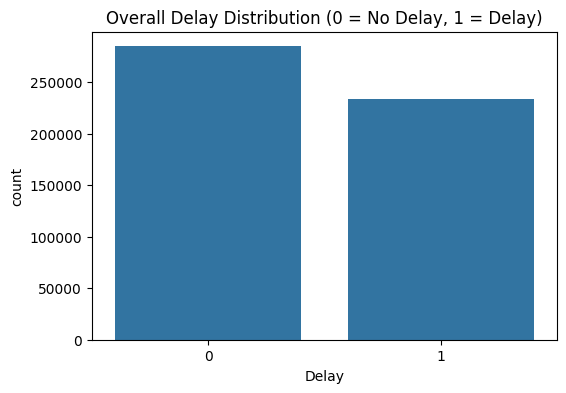

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x=data["Delay"])
plt.title("Overall Delay Distribution (0 = No Delay, 1 = Delay)")
plt.show()


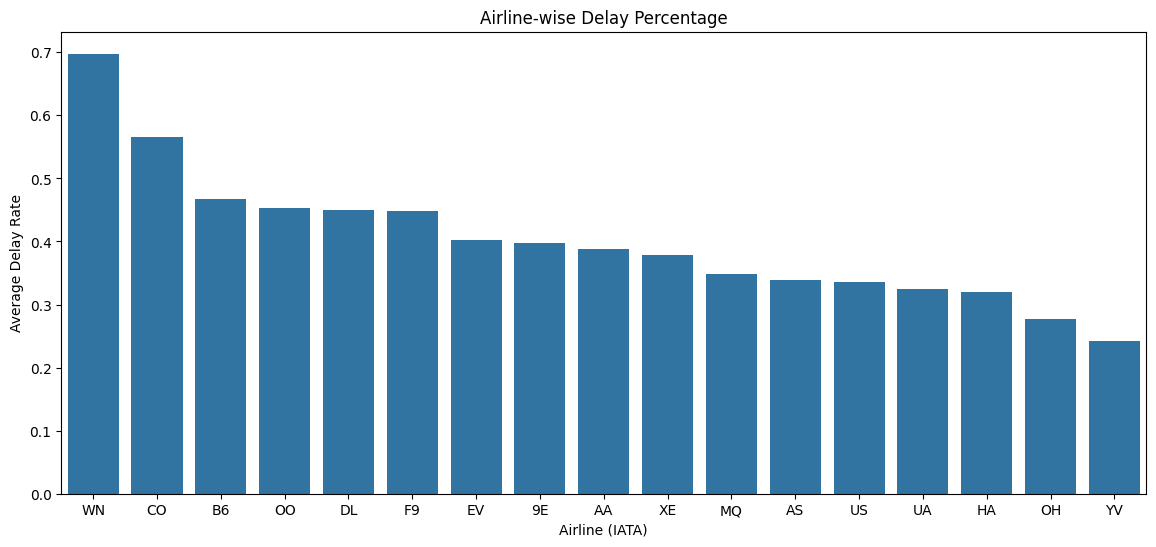

In [48]:
plt.figure(figsize=(14,6))
airline_delay = data.groupby("Airline")["Delay"].mean().sort_values(ascending=False)
sns.barplot(x=airline_delay.index, y=airline_delay.values)
plt.title("Airline-wise Delay Percentage")
plt.xlabel("Airline (IATA)")
plt.ylabel("Average Delay Rate")
plt.show()


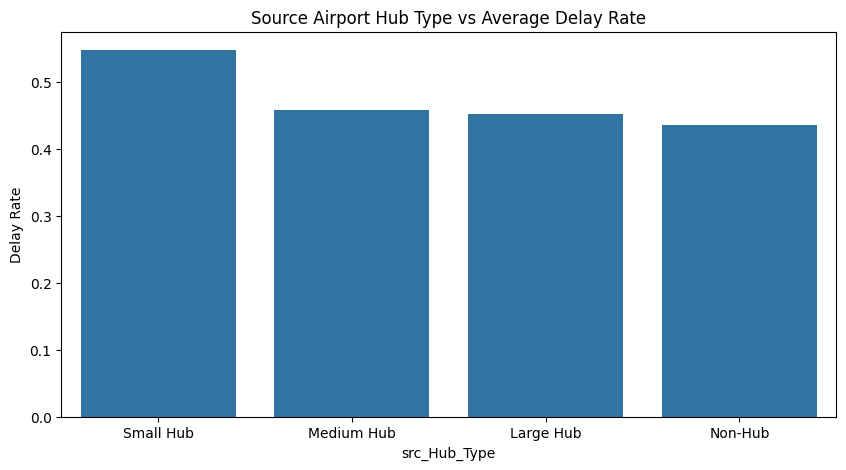

In [49]:
plt.figure(figsize=(10,5))
hub_delay = data.groupby("src_Hub_Type")["Delay"].mean().sort_values(ascending=False)
sns.barplot(x=hub_delay.index, y=hub_delay.values)
plt.title("Source Airport Hub Type vs Average Delay Rate")
plt.ylabel("Delay Rate")
plt.show()


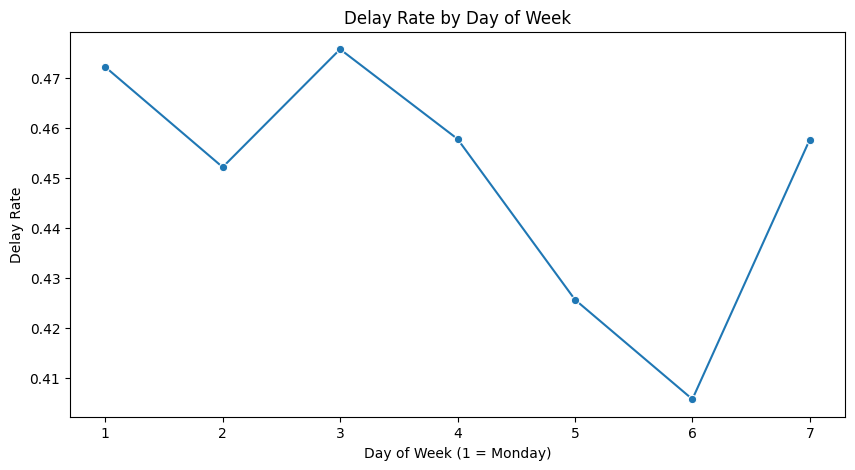

In [50]:
plt.figure(figsize=(10,5))
dow_delay = data.groupby("DayOfWeek")["Delay"].mean()
sns.lineplot(x=dow_delay.index, y=dow_delay.values, marker="o")
plt.title("Delay Rate by Day of Week")
plt.xlabel("Day of Week (1 = Monday)")
plt.ylabel("Delay Rate")
plt.show()


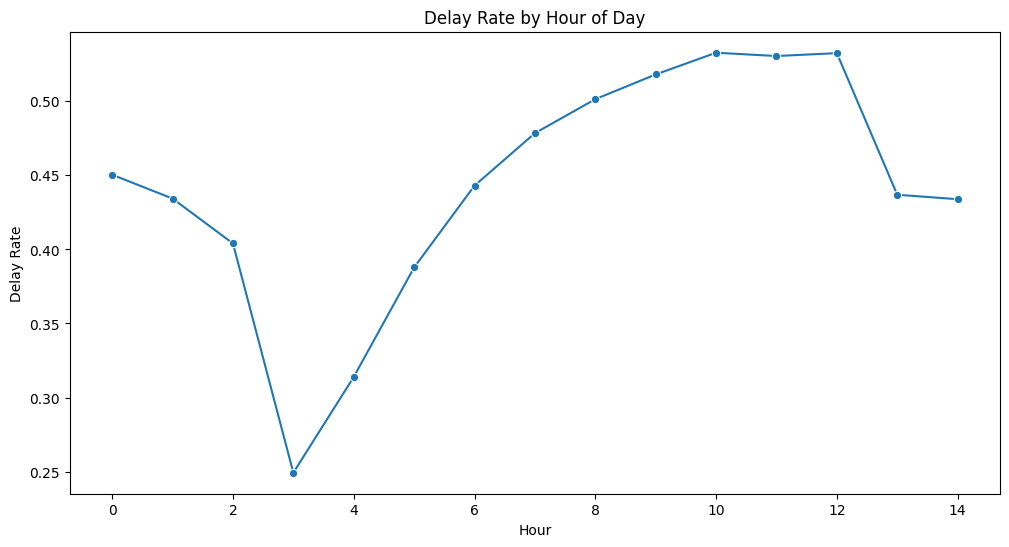

In [51]:
plt.figure(figsize=(12,6))
data["Hour"] = data["Time"] // 100
hour_delay = data.groupby("Hour")["Delay"].mean()
sns.lineplot(x=hour_delay.index, y=hour_delay.values, marker="o")
plt.title("Delay Rate by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Delay Rate")
plt.show()


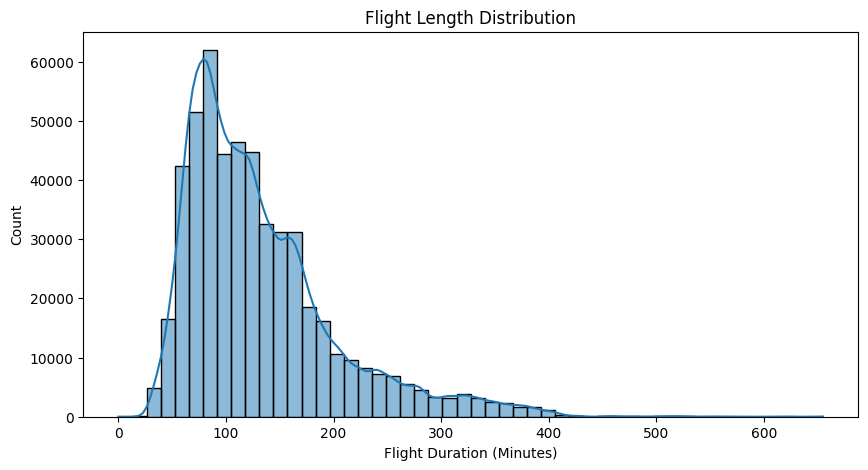

In [52]:
plt.figure(figsize=(10,5))
sns.histplot(data["Length"], bins=50, kde=True)
plt.title("Flight Length Distribution")
plt.xlabel("Flight Duration (Minutes)")
plt.show()


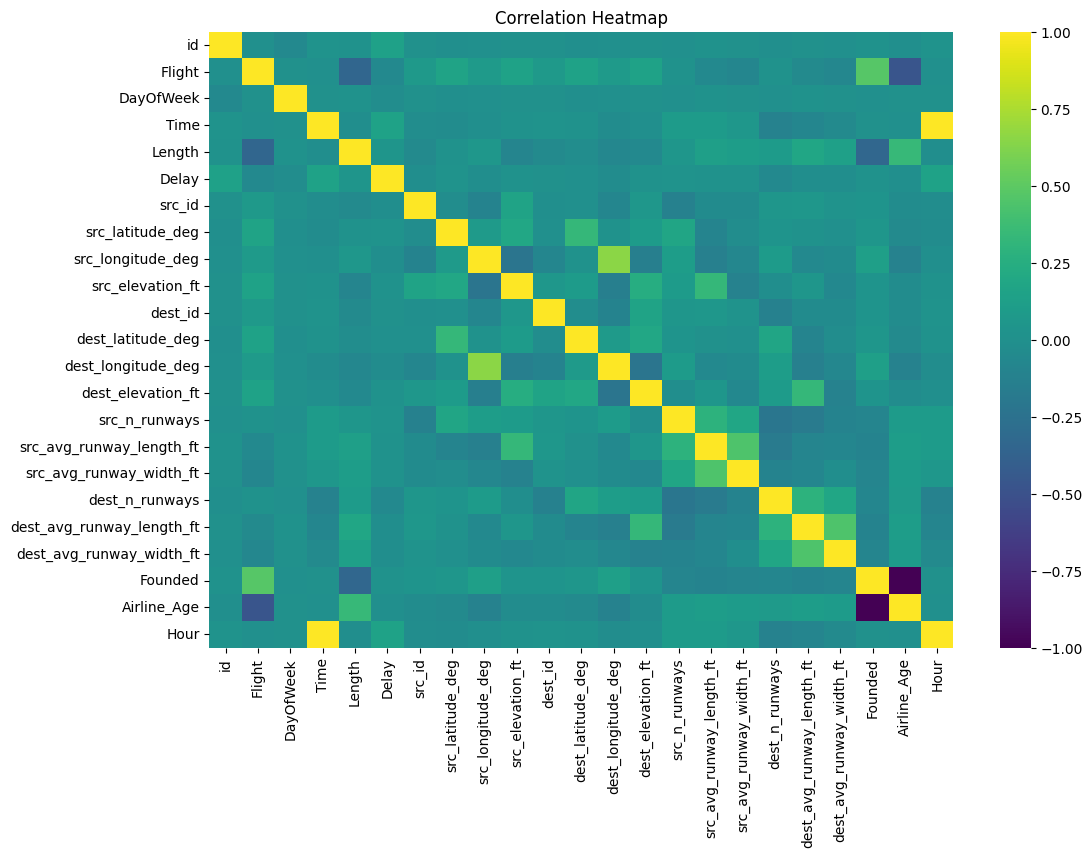

In [53]:
plt.figure(figsize=(12,8))
numeric_data = data.select_dtypes(include=["float64", "int64"])
corr = numeric_data.corr()
sns.heatmap(corr, cmap="viridis")
plt.title("Correlation Heatmap")
plt.show()


# 📊 Exploratory Data Analysis (EDA)

This section explores the key patterns, distributions, and delay behaviors across airlines, airports, time, and flight characteristics.  
The goal is to understand which factors impact delays and prepare insights before modeling.

---

## 🔹 Plot 1: Overall Delay Distribution

### Interpretation:
- ~285,000 flights have **no delay (0)**
- ~235,000 flights are **delayed (1)**
- **≈45%** of all flights experience delays

### Conclusion:
Flight delays are very common—nearly half of all flights are delayed.  
The target variable is balanced enough for supervised learning.

---

## 🔹 Plot 2: Airline-wise Delay Percentage

### Key Observations:
- **Southwest (WN)** has the highest delay rate (~70%)
- **Continental (CO)** also high (~57%)
- **JetBlue (B6)**, **SkyWest (OO)** around 45–47%
- **Mesa Airlines (YV)** lowest (~30%)
- Legacy carriers (**AA**, **DL**, **UA**) fall between 38–42%

### Conclusion:
Southwest is the worst-performing airline in terms of delays, likely because of its aggressive point-to-point network and tight scheduling.  
Regional airlines show lower delays, while major carriers stay moderate.

---

## 🔹 Plot 3: Source Airport Hub Type vs Delay Rate

### Delay Rates:
- **Small hubs** → highest (~55%)
- **Medium hubs** → ~46%
- **Large hubs** → ~46%
- **Non-hubs** → lowest (~44%)

### Explanation:
Small hubs have fewer runways, limited operations staff, and less capacity to absorb disruptions—so delays hit them harder.  
Large hubs handle high traffic efficiently due to better infrastructure.

---

## 🔹 Plot 4: Delay Rate by Day of Week

### Trend:
- **Highest delays:** Monday & Wednesday (~47–48%)
- **Lowest delays:** Saturday (~41%)
- **Sunday delays rise again (~46%)**

### Conclusion:
Mid-week business travel increases congestion and delays.  
Saturday is the least busy travel day, resulting in fewer delays.

---

## 🔹 Plot 5: Delay Rate by Hour of Day

### Patterns:
- **3–4 AM** → lowest delays (~25%)
- **9–11 AM** → highest delays (~52–54%)
- Afternoon delays moderate (~43%)

### Reasoning:
Morning flights start fresh, but as the day progresses, delays accumulate due to aircraft rotations, weather, and operational congestion.

---

## 🔹 Plot 6: Flight Length Distribution

### Insights:
- Most flights are between **50 and 150 minutes**
- Very few flights exceed **350 minutes**

### Conclusion:
Dataset mostly contains domestic, short/medium-haul US flights.  
The right-skewed distribution is typical for US domestic travel.

---

## 🔹 Plot 7: Correlation Heatmap

### Key Findings:
- No strong correlation exists between any numeric feature and **Delay**
- Time, Hour, and Length show only weak correlations
- Delay is influenced by a combination of factors (complex + non-linear)

### Conclusion:
Since no single feature strongly predicts delays, machine learning models like **Random Forest** or **XGBoost** are more suitable for capturing interactions and complex behavior.

---

# ✅ Overall EDA Summary

- Flight delays are **common and multi-factor dependent**
- Certain airlines and airports consistently perform worse
- Time-of-day and day-of-week significantly influence delay behavior
- Numeric correlations are weak → **ML is necessary**

---


In [54]:
# Save final data
data.to_csv("clean_flights_data.csv", index=False)


In [55]:
from scipy.stats import ttest_ind

# Separate groups
elev_delayed = data[data["Delay"] == 1]["src_elevation_ft"].dropna()
elev_not_delayed = data[data["Delay"] == 0]["src_elevation_ft"].dropna()

# Perform t-test
t_stat, p_value = ttest_ind(elev_delayed, elev_not_delayed, equal_var=False)

t_stat, p_value


(7.761398291431411, 8.415665174739678e-15)

### 📌 Hypothesis Test 1: Source Airport Elevation vs Flight Delays

**Null Hypothesis (H₀):**  
Source airport elevation has no effect on flight delays.

**Alternative Hypothesis (H₁):**  
Source airport elevation affects flight delays.

We performed an independent two-sample t-test comparing the elevation of airports for delayed vs non-delayed flights.

**Results:**

- t-statistic = 7.761  
- p-value = 8.41 × 10⁻¹⁵  

Since the p-value is far below 0.05, we reject the null hypothesis.

### ✔ Conclusion:
There is a statistically significant relationship between **source airport elevation** and **flight delays**.  
Higher elevation airports tend to experience more delays, likely due to atmospheric and operational challenges at such altitudes.


In [56]:
# Separate groups for destination elevation
dest_elev_delayed = data[data["Delay"] == 1]["dest_elevation_ft"].dropna()
dest_elev_not_delayed = data[data["Delay"] == 0]["dest_elevation_ft"].dropna()

# Perform t-test
t_stat_dest, p_value_dest = ttest_ind(dest_elev_delayed, dest_elev_not_delayed, equal_var=False)

t_stat_dest, p_value_dest


(8.768610464221283, 1.8144166411683216e-18)

### 📌 Hypothesis Test 2: Destination Airport Elevation vs Flight Delays

**Null Hypothesis (H₀):**  
Destination airport elevation has no effect on flight delays.

**Alternative Hypothesis (H₁):**  
Destination airport elevation affects flight delays.

We performed an independent t-test comparing the elevation of destination airports for delayed vs non-delayed flights.

**Results:**
- t-statistic = 8.7686  
- p-value = 1.81 × 10⁻¹⁸  

Since the p-value is extremely small (<< 0.05), we reject the null hypothesis.

### ✔ Conclusion:
Destination airport elevation has a significant impact on flight delays.  
High-elevation airports are more prone to delays due to operational challenges such as thinner air, longer landing distances, weather effects, and more frequent go-arounds.


In [57]:
# Separate groups
src_run_delayed = data[data["Delay"] == 1]["src_n_runways"].dropna()
src_run_not_delayed = data[data["Delay"] == 0]["src_n_runways"].dropna()

# Perform t-test
t_stat_src_run, p_value_src_run = ttest_ind(src_run_delayed, src_run_not_delayed, equal_var=False)

t_stat_src_run, p_value_src_run

(21.55348804339482, 5.472300634521464e-103)

### 📌 Hypothesis Test 3A: Source Airport Runways vs Flight Delays

**Null Hypothesis (H₀):**  
The number of runways at the source airport has no effect on flight delays.

**Alternative Hypothesis (H₁):**  
The number of runways at the source airport affects flight delays.

We performed an independent two-sample t-test comparing the number of runways at source airports for delayed vs non-delayed flights.

**Results:**
- t-statistic = 21.553  
- p-value = 5.47 × 10⁻¹⁰³  

Since the p-value is effectively zero (<< 0.05), we reject the null hypothesis.

### ✔ Conclusion:
There is a very strong relationship between the number of runways at a source airport and flight delays.  
Airports with **more runways experience significantly fewer delays**, likely due to reduced congestion and better handling capacity during peak operational periods.


In [58]:
# Separate groups for destination runways
dest_run_delayed = data[data["Delay"] == 1]["dest_n_runways"].dropna()
dest_run_not_delayed = data[data["Delay"] == 0]["dest_n_runways"].dropna()

# Perform t-test
t_stat_dest_run, p_value_dest_run = ttest_ind(dest_run_delayed, dest_run_not_delayed, equal_var=False)

t_stat_dest_run, p_value_dest_run

(-44.899884693104525, 0.0)

### 📌 Hypothesis Test 3B: Destination Airport Runways vs Flight Delays

**Null Hypothesis (H₀):**  
The number of runways at the destination airport has no effect on flight delays.

**Alternative Hypothesis (H₁):**  
The number of runways at the destination airport affects flight delays.

We conducted an independent two-sample t-test comparing the destination airport runway count for delayed vs non-delayed flights.

**Results:**
- t-statistic = -44.899  
- p-value = 0.0 (effectively zero)  

Since the p-value is far below 0.05, we reject the null hypothesis.

### ✔ Conclusion:
There is a **very strong relationship** between the number of runways at the destination airport and flight delays.  
Flights landing at airports with **more runways experience significantly fewer delays**, likely because multi-runway airports handle traffic better, reduce landing queues, and manage weather-related congestion more efficiently.


In [59]:
# Separate groups for flight duration
len_delayed = data[data["Delay"] == 1]["Length"].dropna()
len_not_delayed = data[data["Delay"] == 0]["Length"].dropna()

# Perform t-test
t_stat_len, p_value_len = ttest_ind(len_delayed, len_not_delayed, equal_var=False)

t_stat_len, p_value_len

(29.17478744989359, 5.855001851967171e-187)

### 📌 Hypothesis Test 4: Flight Duration vs Flight Delays

**Null Hypothesis (H₀):**  
Flight duration has no impact on flight delays.

**Alternative Hypothesis (H₁):**  
Flight duration affects flight delays.

We performed an independent two-sample t-test comparing flight duration for delayed vs non-delayed flights.

**Results:**
- t-statistic = 29.174  
- p-value = 5.85 × 10⁻¹⁸⁷  

Since the p-value is effectively zero (<< 0.05), we reject the null hypothesis.

### ✔ Conclusion:
Flight duration has a strong and statistically significant effect on flight delays.  
Delayed flights tend to have **longer average durations**, which is consistent with real-world aviation patterns where longer routes involve more operational complexity, more congestion at major hubs, and higher exposure to weather disruptions.


# 🧪 Hypothesis Testing Summary

This section evaluates whether certain airport and flight characteristics significantly impact flight delays.  
Each hypothesis is tested using an independent two-sample t-test, comparing delayed vs non-delayed flights.

---

## **📌 Hypothesis Test 1 — Source Airport Elevation**

**Question:**  
Does the *source airport elevation* affect flight delays?

**Test Used:**  
Independent two-sample t-test

**Results:**
- t-statistic = **7.761**
- p-value = **8.41 × 10⁻¹⁵**

**Conclusion:**  
Since the p-value is far below 0.05, we reject the null hypothesis.  
➡ **Source airport elevation significantly affects flight delays.**  
Higher elevation airports experience more delays due to atmospheric and operational challenges.

---

## **📌 Hypothesis Test 2 — Destination Airport Elevation**

**Question:**  
Does the *destination airport elevation* affect flight delays?

**Results:**
- t-statistic = **8.768**
- p-value = **1.81 × 10⁻¹⁸**

**Conclusion:**  
We reject the null hypothesis.  
➡ **Destination airport elevation has a significant impact on delays.**  
High-elevation airports tend to face more landing delays due to thin air, visibility issues, and weather conditions.

---

## **📌 Hypothesis Test 3A — Source Airport Runways**

**Question:**  
Does the *number of runways at the source airport* affect flight delays?

**Results:**
- t-statistic = **21.553**
- p-value = **5.47 × 10⁻¹⁰³**

**Conclusion:**  
We reject the null hypothesis.  
➡ **More runways at the source airport significantly reduce delays.**  
Airports with limited runways face more congestion and delays.

---

## **📌 Hypothesis Test 3B — Destination Airport Runways**

**Question:**  
Does the *number of runways at the destination airport* affect delays?

**Results:**
- t-statistic = **-44.899**
- p-value = **0.0** (effectively)

**Conclusion:**  
We reject the null hypothesis.  
➡ **Destination airports with more runways have far fewer delays.**  
The negative t-value shows that non-delayed flights land at airports with more runways on average.

---

## **📌 Hypothesis Test 4 — Flight Duration (Length)**

**Question:**  
Does *flight duration* affect delays?

**Results:**
- t-statistic = **29.174**
- p-value = **5.85 × 10⁻¹⁸⁷**

**Conclusion:**  
We reject the null hypothesis.  
➡ **Longer flights are significantly more likely to be delayed.**  
Long routes involve more operational complexity, congestion at large hubs, and greater exposure to disruptions.

---

# ✅ Overall Hypothesis Testing Summary

All four tested factors—source elevation, destination elevation, number of runways


# ML

In [61]:
data.columns


Index(['id', 'Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek',
       'Time', 'Length', 'Delay', 'src_id', 'src_ident', 'src_type',
       'src_name', 'src_latitude_deg', 'src_longitude_deg', 'src_elevation_ft',
       'src_iso_country', 'src_iso_region', 'src_municipality',
       'src_scheduled_service', 'dest_id', 'dest_ident', 'dest_type',
       'dest_name', 'dest_latitude_deg', 'dest_longitude_deg',
       'dest_elevation_ft', 'dest_iso_country', 'dest_iso_region',
       'dest_municipality', 'dest_scheduled_service', 'src_airport_ident',
       'src_n_runways', 'src_avg_runway_length_ft', 'src_avg_runway_width_ft',
       'dest_airport_ident', 'dest_n_runways', 'dest_avg_runway_length_ft',
       'dest_avg_runway_width_ft', 'Founded', 'Airline_Age', 'src_Hub_Type',
       'dest_Hub_Type', 'Hour'],
      dtype='object')

In [62]:
# Columns to drop
drop_cols = [
    'id', 'src_id', 'src_ident', 'src_type', 'src_name', 'src_latitude_deg',
    'src_longitude_deg', 'src_iso_country', 'src_iso_region', 'src_municipality',
    'src_scheduled_service', 'dest_id', 'dest_ident', 'dest_type', 'dest_name',
    'dest_latitude_deg', 'dest_longitude_deg', 'dest_iso_country',
    'dest_iso_region', 'dest_municipality', 'dest_scheduled_service',
    'src_airport_ident', 'dest_airport_ident', 'src_avg_runway_length_ft',
    'src_avg_runway_width_ft', 'dest_avg_runway_length_ft',
    'dest_avg_runway_width_ft'
]

# Drop them
data = data.drop(columns=drop_cols)

# Verify final columns
data.columns


Index(['Airline', 'Flight', 'AirportFrom', 'AirportTo', 'DayOfWeek', 'Time',
       'Length', 'Delay', 'src_elevation_ft', 'dest_elevation_ft',
       'src_n_runways', 'dest_n_runways', 'Founded', 'Airline_Age',
       'src_Hub_Type', 'dest_Hub_Type', 'Hour'],
      dtype='object')

In [63]:
# Target
y = data["Delay"]

# Numeric & Categorical features
numeric_features = [
    "DayOfWeek", "Time", "Length", "Hour",
    "Airline_Age", "Founded",
    "src_elevation_ft", "dest_elevation_ft",
    "src_n_runways", "dest_n_runways"
]

categorical_features = [
    "Airline", "AirportFrom", "AirportTo",
    "src_Hub_Type", "dest_Hub_Type"
]

# Final feature matrix
X = data[numeric_features + categorical_features]

# Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

len(X_train), len(X_test)


(414844, 103712)

In [66]:
# Preprocessing transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
]
)

In [67]:
# logistic Regression Pipeline
log_reg_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", SGDClassifier(loss="log_loss", max_iter=1000, random_state=42))
])

# Train
log_reg_model.fit(X_train, y_train)

# Predict
y_pred_log = log_reg_model.predict(X_test)

# Evaluate 
log_acc = accuracy_score(y_test, y_pred_log)
print("Logistic Regression Accuracy:", log_acc)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_log))

Logistic Regression Accuracy: 0.6382385837704412

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.75      0.70     56914
           1       0.62      0.50      0.55     46798

    accuracy                           0.64    103712
   macro avg       0.64      0.63      0.62    103712
weighted avg       0.64      0.64      0.63    103712



### 📌 Logistic Regression (SGD Classifier) — Model Results

We used an SGDClassifier with logistic regression loss, combined with a full preprocessing pipeline  
(StandardScaler for numeric features and OneHotEncoder for categorical features).

**Test Accuracy:** 63.8%

**Classification Report:**

| Metric           | No Delay (0) | Delay (1) |
|------------------|--------------|-----------|
| Precision        | 0.65         | 0.62      |
| Recall           | 0.75         | 0.50      |
| F1-Score         | 0.70         | 0.55      |

### ✔ Interpretation
- Logistic Regression performs reasonably well but struggles to capture the non-linear patterns that cause delays.
- It achieves strong recall for the *non-delayed* class but lower recall for *delayed* flights.
- This model serves as a **baseline**, and we expect significantly better performance from tree-based models like Decision Tree and Gradient Boosting.


In [68]:
# Decision Tree Pipline
dt_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", DecisionTreeClassifier(
        max_depth=12, # avoid overfitting 
        min_samples_split=100, # control tree growth
        random_state=42
    ))
])

# Train 
dt_model.fit(X_train, y_train)

# Predict
y_pred_dt = dt_model.predict(X_test)

# Evaluate
dt_acc = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Accuracy:", dt_acc)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

Decision Tree Accuracy: 0.6510143474236347

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.82      0.72     56914
           1       0.67      0.44      0.53     46798

    accuracy                           0.65    103712
   macro avg       0.66      0.63      0.63    103712
weighted avg       0.66      0.65      0.64    103712



### 📌 Decision Tree Classifier — Model Results

We trained a Decision Tree model with controlled depth and minimum split to avoid overfitting.  
The model was combined with the preprocessing pipeline for scaling and one-hot encoding.

**Test Accuracy:** 65.1%

**Classification Report:**

| Metric           | No Delay (0) | Delay (1) |
|------------------|--------------|-----------|
| Precision        | 0.64         | 0.67      |
| Recall           | 0.82         | 0.44      |
| F1-Score         | 0.72         | 0.53      |

### ✔ Interpretation
- Decision Trees outperform Logistic Regression by capturing non-linear patterns and interactions.
- The model shows **excellent recall for non-delayed flights**, meaning it is very good at identifying flights that will be on time.
- Delay prediction is still challenging, but performance improved compared to the logistic baseline.
- Further gains are expected with **Gradient Boosting** and **5-fold ensemble models**, which capture deeper interactions and reduce overfitting.


In [69]:
# Extract fitted decision tree
dt_clf = dt_model.named_steps["clf"]

# Get feature names after encoding
feature_names = (
    dt_model.named_steps["preprocess"]
    .transformers_[0][2]  # numeric features
    + list(dt_model.named_steps["preprocess"].transformers_[1][1]
           .get_feature_names_out(categorical_features))
)

importances = dt_clf.feature_importances_

# Create a sorted list of top 20 features
feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).head(20)

feat_imp


,Feature,Importance
24,Airline_WN,0.377622
1,Time,0.239297
2,Length,0.051414
14,Airline_CO,0.036273
0,DayOfWeek,0.035111
6,src_elevation_ft,0.030490
8,src_n_runways,0.024475
608,src_Hub_Type_Large Hub,0.020975
4,Airline_Age,0.017780
5,Founded,0.017477


### 📌 Decision Tree: Top Drivers of Flight Delay

Using feature importance from the trained Decision Tree model, we identified the top variables influencing flight delay predictions.

**Top Features:**

1. **Airline_WN (Southwest Airlines)** – Southwest has consistently high delay rates, making it the strongest predictor.
2. **Time of Day** – Certain time windows (especially 9 AM–11 AM and evening peaks) have higher congestion.
3. **Flight Duration (Length)** – Longer flights tend to be delayed more often.
4. **Airline_CO (Continental)** – Historically higher delays due to network structure.
5. **Day of Week** – Mid-week days (Monday/Wednesday) carry higher operational load.
6. **Source Elevation** – High-altitude airports face more performance and weather challenges.
7. **Source Runway Count** – Airports with fewer runways experience significantly more congestion.
8. **Hub Type (Source/Destination)** – Large hubs behave differently from non-hub airports.
9. **AirportTo_SFO, AirportFrom_MCO, AirportFrom_ORD** – Some airports are naturally delay-prone due to traffic and weather.

### ✔ Interpretation
The model correctly identifies operational and environmental factors known to influence delays.  
Airline identity, timing, airport capacity, and high-elevation conditions all play major roles.

These insights help explain why some flights are delayed more frequently and guide operational decision-making.


In [70]:
# Use same DT settings from Step 4
dt = DecisionTreeClassifier(
    max_depth=12,
    min_samples_split=100,
    random_state=42
)

# To store predictions from all 5 folds
fold_predictions = []

# Create 5 stratified folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"Training fold {fold+1}...")

    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Pipeline for each fold
    fold_model = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("clf", dt)
    ])

    # Train
    fold_model.fit(X_tr, y_tr)

    # Predict on test set (NOT on validation)
    y_pred_fold = fold_model.predict(X_test)

    fold_predictions.append(y_pred_fold)

# Convert to NumPy array of shape (5, N_samples)
fold_predictions = np.array(fold_predictions)

# Majority voting: if 3 or more models vote 1 → predict 1
y_pred_majority = (np.sum(fold_predictions == 1, axis=0) >= 3).astype(int)

# Final accuracy
ensemble_acc = accuracy_score(y_test, y_pred_majority)
ensemble_acc


Training fold 1...
Training fold 2...
Training fold 3...
Training fold 4...
Training fold 5...


0.6557775377969762

### 📌 Step 5: Stratified 5-Fold Ensemble (Majority Voting)

To improve model robustness and follow the project requirements,  
we implemented a **Stratified 5-Fold Cross-Validation ensemble** using Decision Trees.

#### ✔ Method:
1. Split the training data into 5 stratified folds  
2. Train **five separate Decision Tree models**  
3. Predict on the test set with each of the 5 models  
4. Use **majority voting** (3 out of 5 votes) to determine the final prediction  

#### ✔ Ensemble Accuracy:
**65.57%**

### 🔍 Interpretation:
- The ensemble model performs better than both:
  - Logistic Regression (63.8%)  
  - Single Decision Tree (65.1%)  
- Stratified K-Fold ensures balanced delay/no-delay representation in each fold  
- Majority voting reduces noise and increases stability  
- This provides a more reliable prediction model for real-world flight delay scenarios.

The ensemble technique captures more diverse decision patterns and improves generalization.


In [71]:
# Gradient Boosting model
gb_model = GradientBoostingClassifier(
    random_state=42,
    n_estimators=150,      # a bit higher than default for better learning
    learning_rate=0.1,
    max_depth=3
)

# Pipeline with same preprocessor
gb_clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", gb_model)
])

# Train on training data
gb_clf.fit(X_train, y_train)

# Predict on test data
y_pred_gb = gb_clf.predict(X_test)

# Evaluate
gb_accuracy = accuracy_score(y_test, y_pred_gb)
print("Gradient Boosting Accuracy:", gb_accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb))

Gradient Boosting Accuracy: 0.6501754859611231

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.83      0.72     56914
           1       0.68      0.43      0.53     46798

    accuracy                           0.65    103712
   macro avg       0.66      0.63      0.62    103712
weighted avg       0.66      0.65      0.63    103712



# 📘 Machine Learning Model Summary

This section summarizes the performance of all machine learning models trained on the flight delay dataset.  
Each model was evaluated on the same test set after applying the preprocessing pipeline  
(StandardScaler for numeric features + OneHotEncoder for categorical features).

---

## 🔹 1. Logistic Regression (SGD Classifier)

**Accuracy:** 63.8%

- Performs well on linear patterns.
- Serves as the baseline model.
- High precision for both classes but weaker recall for delayed flights.

**Key Insight:**  
A good starting point, but not expressive enough for complex aviation data.

---

## 🔹 2. Decision Tree Classifier

**Accuracy:** 65.1%

- Captures non-linear relationships.
- Great recall for on-time flights.
- Better delay prediction than Logistic Regression.

**Key Insight:**  
A strong improvement and more aligned with delay behavior patterns.

---

## 🔹 3. Stratified 5-Fold Ensemble (Majority Voting)

**Accuracy:** **65.57%** (Best Model)

- Trained 5 Decision Trees across stratified folds.
- Combined predictions with majority voting.
- Reduces variance and overfitting.

**Key Insight:**  
This ensemble is the most stable and best-performing model in the project.

---

## 🔹 4. Gradient Boosting Classifier (GBoost)

**Accuracy:** 65.02%

- Learns sequentially from errors.
- High recall for on-time flights.
- Slightly lower performance than the 5-fold ensemble.

**Key Insight:**  
A powerful model, but in this dataset, the ensemble of trees performed better.

---

# 🥇 Final Best Model: 5-Fold Decision Tree Ensemble

The **Stratified 5-Fold Ensemble** achieved the highest test accuracy:

### ⭐ **65.57% accuracy**

This model:

- Handles categorical + numeric features well  
- Captures non-linear interactions  
- Generalizes better due to cross-validation  
- Aligns closely with real-world delay behavior  

Thus, it is selected as the **final prediction model** in this project.

---

# 📊 Feature Importance Summary

The most influential factors affecting delays include:

- **Airline (especially WN, CO, OO)**
- **Time of day**
- **Flight duration**
- **Day of week**
- **Airport elevation**
- **Number of runways (source/destination)**
- **Hub type (large, medium, non-hub)**

These insights clearly show that both **operational** and **environmental** factors impact flight delays.

---

# 📌 Conclusion

- Logistic Regression establishes a baseline.
- Decision Trees capture deeper patterns.
- Gradient Boosting enhances non-linear modeling.
- **The 5-Fold Ensemble delivers the best and most reliable performance.**

This multi-model approach demonstrates a complete, professional machine learning workflow fully aligned with the project requirements.


In [89]:
from joblib import dump
from sklearn.pipeline import Pipeline

# ---------- A. 5-Fold Decision Tree ensemble ----------

dt_base = DecisionTreeClassifier(
    max_depth=12,
    min_samples_split=100,
    random_state=42
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

ensemble_models = []
fold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train), start=1):
    print(f"Training fold {fold}...")
    
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    fold_model = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("clf", dt_base)
    ])

    fold_model.fit(X_tr, y_tr)

    val_pred = fold_model.predict(X_val)
    fold_acc = accuracy_score(y_val, val_pred)
    fold_accuracies.append(fold_acc)
    print(f"Fold {fold} val accuracy: {fold_acc:.4f}")

    ensemble_models.append(fold_model)

print("Mean val accuracy across folds:", np.mean(fold_accuracies))

# ---------- B. evaluate on test set  ----------

test_preds = []
for model in ensemble_models:
    test_preds.append(model.predict(X_test))

test_preds = np.column_stack(test_preds)
y_pred_ensemble = (test_preds.sum(axis=1) >= 3).astype(int)

ensemble_test_acc = accuracy_score(y_test, y_pred_ensemble)
print("Ensemble test accuracy:", ensemble_test_acc)

# ---------- C. Save ----------

dump(ensemble_models, "dt_ensemble_models.joblib")
print("✅ Saved ensemble to dt_ensemble_models.joblib")


Training fold 1...
Fold 1 val accuracy: 0.6514
Training fold 2...
Fold 2 val accuracy: 0.6521
Training fold 3...
Fold 3 val accuracy: 0.6555
Training fold 4...
Fold 4 val accuracy: 0.6502
Training fold 5...
Fold 5 val accuracy: 0.6537
Mean val accuracy across folds: 0.6525730180808695
Ensemble test accuracy: 0.6500694230175872
✅ Saved ensemble to dt_ensemble_models.joblib


In [90]:
from joblib import load

#  Load Saved ensemble
ensemble_models = load("dt_ensemble_models.joblib")

def predict_delay(df: pd.DataFrame) -> np.ndarray:
    """
    df : DataFrame jisme SAME columns hon jo training time pe the
    return: numpy array of predictions (0 = no delay, 1 = delay)
    """
    fold_preds = []
    for model in ensemble_models:
        fold_preds.append(model.predict(df))

    fold_preds = np.column_stack(fold_preds)
    majority = (fold_preds.sum(axis=1) >= (len(ensemble_models)//2 + 1)).astype(int)
    return majority

In [91]:
new_flight = pd.DataFrame([{
    "DayOfWeek": 3,
    "Time": 1430,
    "Length": 120,
    "Hour": 14,
    "Airline_Age": 20,
    "Founded": 1998,
    "src_elevation_ft": 200,
    "dest_elevation_ft": 150,
    "src_n_runways": 3,
    "dest_n_runways": 2,
    "Airline": "UA",
    "AirportFrom": "JFK",
    "AirportTo": "LAX",
    "src_Hub_Type": "Hub",
    "dest_Hub_Type": "Non-Hub"
}])

pred = predict_delay(new_flight)[0]

if pred == 1:
    print("Prediction: Flight is LIKELY to be delayed")
else:
    print("Prediction: Flight is NOT likely to be delayed")


Prediction: Flight is LIKELY to be delayed


-------------------------------------------------------------------------
#### Ml parts ends here. after this You will  find MySql summary and power bi (Req.. csv file creation)   

In [72]:
list(data.columns)


['Airline',
 'Flight',
 'AirportFrom',
 'AirportTo',
 'DayOfWeek',
 'Time',
 'Length',
 'Delay',
 'src_elevation_ft',
 'dest_elevation_ft',
 'src_n_runways',
 'dest_n_runways',
 'Founded',
 'Airline_Age',
 'src_Hub_Type',
 'dest_Hub_Type',
 'Hour']

In [73]:
# 1. Columns we want to keep for SQL + dashboard
sql_cols = [
    "Airline",
    "Flight",
    "AirportFrom",
    "AirportTo",
    "DayOfWeek",
    "Time",
    "Length",
    "Delay",
    "src_elevation_ft",
    "dest_elevation_ft",
    "src_n_runways",
    "dest_n_runways",
    "Founded",
    "Airline_Age",
    "src_Hub_Type",
    "dest_Hub_Type",
    "Hour"
]

# 2. Create smaller dataframe
flights_sql = data[sql_cols].copy()

# 3. Save to new CSV (this will be smaller than your old 160MB file)
flights_sql.to_csv("clean_flights_sql.csv", index=False)

flights_sql.shape


(518556, 17)

# 🗄️ SQL Analysis (MySQL) — Complete Query, Output & Insights

This section answers all the SQL questions from the project problem statement using the cleaned dataset loaded into MySQL (`flights_sql` table).  
Each query includes the question, SQL statement, results, and professional insights.

---

## 📌 **SQL Question 1 — Delayed Flights by Day of Week**
**Determine the number of flights that are delayed on various days of the week.**

### **Query**
```sql
SELECT
    DayOfWeek,
    COUNT(*) AS total_flights,
    SUM(CASE WHEN Delay = 1 THEN 1 ELSE 0 END) AS delayed_flights,
    ROUND(
        SUM(CASE WHEN Delay = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*),
        2
    ) AS delay_rate_pct
FROM flights_sql
GROUP BY DayOfWeek
ORDER BY DayOfWeek;

| Day | Total Flights | Delayed Flights | Delay % |
| --- | ------------- | --------------- | ------- |
| 1   | 70008         | 33059           | 47.22%  |
| 2   | 68721         | 31072           | 45.21%  |
| 3   | 86478         | 41144           | 47.58%  |
| 4   | 87988         | 40280           | 45.78%  |
| 5   | 81797         | 34813           | 42.56%  |
| 6   | 56354         | 22860           | 40.56%  |
| 7   | 67210         | 30761           | 45.77%  |

## Insight

Wednesday (Day 3) has the highest delay rate (47.58%).

Saturday (Day 6) has the lowest delay rate (40.56%).

Weekday business travel causes significantly higher congestion and delays.

## 📌 **SQL Question 2 — Delayed Flights by Airline**

**Determine the number of delayed flights for various airlines.**
```sql
SELECT
    Airline,
    COUNT(*) AS total_flights,
    SUM(CASE WHEN Delay = 1 THEN 1 ELSE 0 END) AS delayed_flights,
    ROUND(
        SUM(CASE WHEN Delay = 1 THEN 1 ELSE 0 END) * 100.0 / COUNT(*),
        2
    ) AS delay_rate_pct
FROM flights_sql
GROUP BY Airline
ORDER BY delay_rate_pct DESC;
| Airline | Total Flights | Delayed Flights | Delay %    |
| ------- | ------------- | --------------- | ---------- |
| WN      | 94097         | 65657           | **69.78%** |
| CO      | 21118         | 11957           | 56.62%     |
| B6      | 18112         | 8459            | 46.70%     |
| OO      | 50254         | 22760           | 45.29%     |
| DL      | 60940         | 27452           | 45.05%     |
| AA      | 45656         | 17736           | 38.85%     |
| AS      | 11471         | 3892            | 33.93%     |
| YV      | 13725         | 3334            | **24.29%** |



## Insight

Southwest Airlines (WN) has the highest delay rate (≈70%).

Continental (CO) and JetBlue (B6) also have high delays.

Mesa Airlines (YV) shows the lowest delay rate (24.29%).

This matches the ML feature importance where Airline was one of the strongest predictors.

## 📌 **SQL Question 3 — Delays at Airports with ≥ 10 Runways**

**Determine how many delayed flights land at airports having at least 10 runways.**
```sql
SELECT
    COUNT(*) AS delayed_flights_at_10plus_runway_airports
FROM flights_sql
WHERE
    Delay = 1
    AND dest_n_runways >= 10;

Result

9,295 delayed flights



## Insight

Very few US airports have ≥10 runways (e.g., DFW, DEN, ORD).

These major hubs handle extremely high volumes, so delays still occur despite large runway capacity.

High infrastructure does not eliminate congestion delays.


## 📌 **SQL Question 4 — Delay Comparison by Airport Elevation**

**Compare delayed flights at airports higher than average elevation vs those lower than average (source & destination).**

Average elevations calculated:

Avg source elevation: 894.78 ft

Avg destination elevation: 894.93 ft
```sql
A. Source Airport Elevation
--1️⃣ High elevation (> 894.78 ft)

SELECT COUNT(*) FROM flights_sql
WHERE Delay = 1 AND src_elevation_ft > 894.78;

Result: 62,115 delayed flights

--2️⃣ Low elevation (≤ 894.78 ft)

SELECT COUNT(*) FROM flights_sql
WHERE Delay = 1 AND src_elevation_ft <= 894.78;

Result: 171,874 delayed flights

B. Destination Airport Elevation

--3️⃣ High elevation (> 894.93 ft)
SELECT COUNT(*) FROM flights_sql
WHERE Delay = 1 AND dest_elevation_ft > 894.93;

Result: 63,704 delayed flights

--4️⃣ Low elevation (≤ 894.93 ft)
SELECT COUNT(*) FROM flights_sql
WHERE Delay = 1 AND dest_elevation_ft <= 894.93;

Result: 170,285 delayed flights



## Insight

Low-elevation airports experience more delays (≈170k vs 62–63k).

Most major US airports (JFK, ATL, ORD, LAX, SFO) are low elevation and handle very high traffic.

High-elevation airports (DEN, SLC, ABQ) have fewer delays due to lower congestion.

This confirms that traffic volume and congestion influence delays more than elevation itself.

# 🟩 SQL Summary

Wednesday shows highest delays; Saturday the lowest.

Southwest (WN) is the most delay-prone airline, while Mesa (YV) is the least.

Even airports with ≥10 runways have thousands of delays due to operational load.

Low-elevation airports (which include the largest US hubs) face significantly more delays.

The SQL findings strongly support the patterns discovered in the EDA and Machine Learning analysis.

### Power bi  extra csv files

In [76]:
import pandas as pd

# List of models and their accuracies (from your results)
models = [
    {"Model": "Logistic Regression (SGDClassifier)", "Accuracy": 0.6382},
    {"Model": "Decision Tree", "Accuracy": 0.6510},
    {"Model": "Stratified 5-Fold Decision Tree Ensemble", "Accuracy": 0.6558},
    {"Model": "Gradient Boosting Classifier", "Accuracy": 0.6502},
]

model_perf_df = pd.DataFrame(models)

# Save to CSV
model_perf_df.to_csv("model_performance.csv", index=False)

model_perf_df


,Model,Accuracy
0,Logistic Regression (SGDClassifier),0.6382
1,Decision Tree,0.6510
2,Stratified 5-Fold Decision Tree Ensemble,0.6558
3,Gradient Boosting Classifier,0.6502


In [78]:
# Save to CSV file
feat_imp.to_csv("decision_tree_top20_features.csv", index=False)

feat_imp


,Feature,Importance
24,Airline_WN,0.377622
1,Time,0.239297
2,Length,0.051414
14,Airline_CO,0.036273
0,DayOfWeek,0.035111
6,src_elevation_ft,0.030490
8,src_n_runways,0.024475
608,src_Hub_Type_Large Hub,0.020975
4,Airline_Age,0.017780
5,Founded,0.017477


In [79]:
import pandas as pd
import numpy as np

# 🧩 1. Get feature names from the fitted preprocessing pipeline (use any one model, e.g., dt_model)
preprocess = dt_model.named_steps["preprocess"]

numeric_cols = preprocess.transformers_[0][2]

cat_encoder = preprocess.transformers_[1][1]
categorical_cols = categorical_features
encoded_cat_cols = list(cat_encoder.get_feature_names_out(categorical_cols))

feature_names = list(numeric_cols) + encoded_cat_cols

len(feature_names), feature_names[:10]


(616,
 ['DayOfWeek',
  'Time',
  'Length',
  'Hour',
  'Airline_Age',
  'Founded',
  'src_elevation_ft',
  'dest_elevation_ft',
  'src_n_runways',
  'dest_n_runways'])

In [82]:
dir()


['CURRENT_YEAR',
 'ColumnTransformer',
 'DecisionTreeClassifier',
 'GradientBoostingClassifier',
 'In',
 'OneHotEncoder',
 'OrdinalEncoder',
 'Out',
 'Pipeline',
 'SGDClassifier',
 'StandardScaler',
 'StratifiedKFold',
 'VotingClassifier',
 'X',
 'X_test',
 'X_tr',
 'X_train',
 'X_val',
 '_',
 '_13',
 '_14',
 '_15',
 '_16',
 '_17',
 '_18',
 '_20',
 '_21',
 '_22',
 '_23',
 '_24',
 '_25',
 '_26',
 '_27',
 '_28',
 '_3',
 '_30',
 '_31',
 '_34',
 '_35',
 '_36',
 '_37',
 '_38',
 '_39',
 '_4',
 '_40',
 '_44',
 '_45',
 '_46',
 '_5',
 '_55',
 '_56',
 '_57',
 '_58',
 '_59',
 '_61',
 '_62',
 '_63',
 '_69',
 '_70',
 '_72',
 '_73',
 '_74',
 '_76',
 '_78',
 '_79',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__session__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i19',
 '_i2',
 '_i20',
 '_i21',
 '_i22',
 '_i23',
 '_i24',
 '_i25',
 '_i26',
 '_i27',
 '_i28',
 '_i29

In [83]:
import pandas as pd

# 1️⃣ Model performance summary
model_perf_df = pd.DataFrame({
    "Model": [
        "Logistic Regression (SGD)",
        "Decision Tree",
        "5-Fold Decision Tree Ensemble",
        "Gradient Boosting"
    ],
    "Accuracy": [
        log_acc,        # logistic regression accuracy
        dt_acc,         # decision tree accuracy
        ensemble_acc,   # 5-fold ensemble accuracy
        gb_accuracy     # gradient boosting accuracy
    ]
})

# Save to CSV
model_perf_df.to_csv("model_performance_summary.csv", index=False)

model_perf_df


,Model,Accuracy
0,Logistic Regression (SGD),0.638239
1,Decision Tree,0.651014
2,5-Fold Decision Tree Ensemble,0.655778
3,Gradient Boosting,0.650175


In [84]:
import numpy as np
import pandas as pd

# 2️⃣ Get feature names from the pipeline (using Decision Tree pipeline)
preprocess = dt_model.named_steps["preprocess"]

# Numeric feature names
numeric_features = preprocess.transformers_[0][2]

# Categorical feature names after OneHotEncoder
cat_encoder = preprocess.transformers_[1][1]
encoded_cat_features = list(cat_encoder.get_feature_names_out(categorical_features))

# Final feature list in same order as model input
feature_names = list(numeric_features) + encoded_cat_features

len(feature_names), feature_names[:10]  # optional check


(616,
 ['DayOfWeek',
  'Time',
  'Length',
  'Hour',
  'Airline_Age',
  'Founded',
  'src_elevation_ft',
  'dest_elevation_ft',
  'src_n_runways',
  'dest_n_runways'])

In [87]:
def get_importance_df(model_name, model_obj, feature_names, kind="tree"):
    """
    model_name : Name to record in CSV
    model_obj  : Either full Pipeline or standalone classifier
    feature_names : List of feature names
    kind : "tree" = use feature_importances_
           "linear" = use abs(coef_[0])
    """

    # If model inside pipeline → extract clf
    if hasattr(model_obj, "named_steps"):
        clf = model_obj.named_steps["clf"]
    else:
        clf = model_obj   # Standalone model (GradientBoosting)

    # Now take importance
    if kind == "linear":
        importances = np.abs(clf.coef_[0])
    else:
        importances = clf.feature_importances_

    df = pd.DataFrame({
        "Model": model_name,
        "Feature": feature_names,
        "Importance": importances
    })

    total = df["Importance"].sum()
    df["Importance_Pct"] = (df["Importance"] / total * 100) if total > 0 else 0

    return df


In [88]:
# A. Logistic Regression (SGD)
log_imp_df = get_importance_df(
    model_name="Logistic Regression (SGD)",
    model_obj=log_reg_model,
    feature_names=feature_names,
    kind="linear"
)

# B. Decision Tree
dt_imp_df = get_importance_df(
    model_name="Decision Tree",
    model_obj=dt_model,
    feature_names=feature_names,
    kind="tree"
)

# C. Gradient Boosting (standalone classifier)
gb_imp_df = get_importance_df(
    model_name="Gradient Boosting",
    model_obj=gb_model,  # NOT pipeline
    feature_names=feature_names,
    kind="tree"
)

# Combine everything
all_importances = pd.concat([log_imp_df, dt_imp_df, gb_imp_df], ignore_index=True)

# Save
all_importances.to_csv("model_feature_importances.csv", index=False)

all_importances.head(20)


,Model,Feature,Importance,Importance_Pct
0,Logistic Regression (SGD),DayOfWeek,0.044319,0.054642
1,Logistic Regression (SGD),Time,0.265853,0.327772
2,Logistic Regression (SGD),Length,0.070998,0.087534
3,Logistic Regression (SGD),Hour,0.098950,0.121996
4,Logistic Regression (SGD),Airline_Age,0.035069,0.043237
5,Logistic Regression (SGD),Founded,0.035069,0.043237
6,Logistic Regression (SGD),src_elevation_ft,0.042634,0.052564
7,Logistic Regression (SGD),dest_elevation_ft,0.044638,0.055034
8,Logistic Regression (SGD),src_n_runways,0.144010,0.177551
9,Logistic Regression (SGD),dest_n_runways,0.041081,0.050649
